In [1]:
import os
import sqlite3
import psycopg2
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import boxcox
import matplotlib.pyplot as plt
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine, inspect, MetaData, Table

EXTRACT & LOAD RAW DATA TO DATABASE

In [2]:
def extract_data(folder_path):
    """
    Extract CSV data from the specified folder.
    
    arg:
    folder_path: Path to the folder containing CSV files.
    return: data_frames: list of pandas dataframes containing data from each of the csv files.
    
    """
    
    data_frames = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path)
            df['file_name'] = file_name # add a column to store the file name           
            data_frames.append(df)
            
    return data_frames

In [3]:
folder_path = r"C:\Users\admin\Desktop\Projects\Project FitBit\Fitabase Dataset"
data_frames = extract_data(folder_path)

In [4]:
USERNAME = 'fitbase'
PASSWORD = 'fitbase'
SERVER = 'localhost'
DATABASE = 'projectfitbase'

# Define your PostgreSQL database connection string
conn_str = f'postgresql://{USERNAME}:{PASSWORD}@{SERVER}/{DATABASE}'

# Establish a connection to the PostgreSQL database
engine = create_engine(conn_str)

Inspector = inspect(engine)

# Create a sessionmaker to handle transactions
Session = sessionmaker(bind=engine)

# Loop through each DataFrame in data_frames list
for df in data_frames:
    # Extract the file name from the DataFrame
    table_name = df['file_name'].iloc[0].split('.')[0]

    # Begin a transaction
    with Session.begin() as session:
        # Check if the table already exists in the database
        table_exists = Inspector.has_table(table_name)

        if not table_exists:
            # If the table does not exist, create it
            df.head(0).to_sql(table_name, engine, index=False)  # Create empty table structure

        # Load the DataFrame into the database table
        df.to_sql(table_name, engine, if_exists='append', index=False)  # Append data to the table

print("ETL process completed successfully.")

EXTRACT, TRANSFORM & LOAD FROM DATABASE TO WAREHOUSE

# Transformation

<b>1. Handle Duplicates:</b>

Are there duplicate rows in the dataset that need to be removed?

How will the removal of duplicates impact the analysis or modeling tasks?

In [5]:
def handle_duplicates(data_frames):
    """
    Remove duplicates from each DataFrame in the list.
    
    Parameters:
        data_frames (list): List of DataFrames.
        
    Returns:
        list: List of DataFrames with duplicates removed.
    """
    cleansed_data_frames = []
    for df in data_frames:
        cleansed_data_frames.append(df.drop_duplicates())
    return cleansed_data_frames

<b>2. Handle Missing Values:</b>

Are there columns with over 90% missing values and rows with 100% missing values in the dataset?

How will the removal of duplicates impact the analysis or modeling tasks?

In [6]:
def handle_missing_values(data_frames, column_threshold=0.9):
    """
    Handle missing values in a list of DataFrames by dropping columns with over 90% missing values
    and rows that are 100% null.

    Parameters:
        data_frames (list): List of pandas DataFrames.
        column_threshold (float): Threshold for dropping columns based on the proportion of missing values.
    
    Returns:
        cleaned_data_frames (list): List of DataFrames with missing values handled.
    """
    cleaned_data_frames = []

    for df in data_frames:

        # Make a copy of the DataFrame
        df = df.copy()
        
        # Drop columns with over 90% missing values
        df.dropna(axis=1, thresh=int(column_threshold * len(df)), inplace=True)
        
        # Drop rows that are 100% null
        df.dropna(axis=0, how='all', inplace=True)
        
        # Reset index
        df.reset_index(drop=True, inplace=True)

        cleaned_data_frames.append(df)

    return cleaned_data_frames

<b>3. Data Type:</b> 

What are the data types of the values? (Numeric, categorical, or other?)

If numeric, are they continuous or discrete?

In [7]:
def classify_datatypes(dataframes):
    """
    Classify columns in a list of DataFrames into different data types: numeric, datetime, date, and categorical.

    Parameters:
        dataframes (list): A list of pandas DataFrames.

    Returns:
        numeric_columns_all (list): List of columns classified as numeric across all DataFrames.
        datetime_columns_all (list): List of columns classified as datetime across all DataFrames.
        date_columns_all (list): List of columns classified as date across all DataFrames.
        categorical_columns_all (list): List of columns classified as categorical across all DataFrames.
    """
    numeric_columns_all = []
    datetime_columns_all = []
    date_columns_all = []
    categorical_columns_all = []

    numeric_columns, datetime_columns, date_columns, categorical_columns = [], [], [], []
    for df in dataframes:

        for col in df.columns:
            if df[col].dtype in ['float64', 'int64']:
                numeric_columns.append(col)
            elif df[col].astype(str).str.match(r'\d+/\d+/\d+ \d+:\d+:\d+ [AP]M').all():
                datetime_columns.append(col)
            elif df[col].astype(str).str.match(r'\d+/\d+/\d+').all():
                date_columns.append(col)
            else:
                categorical_columns.append(col)

        numeric_columns_all.extend(numeric_columns)
        datetime_columns_all.extend(datetime_columns)
        date_columns_all.extend(date_columns)
        categorical_columns_all.extend(categorical_columns)

    return numeric_columns_all, datetime_columns_all, date_columns_all, categorical_columns_all, data_frames

<b>4. Data Context:</b>

What do the values represent? (Measurements, counts, percentages, etc.)

What is the context or domain of the data?

In [8]:
def classify_numeric_columns(data_frames, numeric_columns_all, threshold=0.06):
    """
    Classify numeric columns in a list of DataFrames into count columns and measurement columns.
    
    Parameters:
        data_frames (list): List of DataFrames.
        numeric_columns_all (list): List of all numeric columns across all DataFrames.
        threshold (float): Threshold to differentiate count columns from measurement columns based on the proportion of unique values.
                           Columns with a proportion of unique values less than or equal to the threshold are classified as count columns.
    
    Returns:
        count_columns_all (list): List of all count columns across all DataFrames.
        measurement_columns_all (list): List of all measurement columns across all DataFrames.
    """

    count_columns_all = []
    measurement_columns_all = []

    count_columns, measurement_columns = [], []
    for df in data_frames:
        for col in df.columns:
            if col in numeric_columns_all: # Check if column exists in list of columns that are int
                unique_ratio = df[col].nunique() / len(df[col])
                
                if df[col].astype(str).str.match(r'0\..*').any():
                    measurement_columns.append(col)
                   
                elif unique_ratio <= 0.06:
                    count_columns.append(col)
                
                elif col.endswith('Id'):
                    count_columns.append(col)

                else:
                    measurement_columns.append(col)
                         
    count_columns_all.extend(count_columns)
    measurement_columns_all.extend(measurement_columns)

    return count_columns_all, measurement_columns_all, data_frames


<b>4. Analysis Requirements:</b>

What are the requirements of your analysis or modeling tasks?

Are there specific algorithms or analyses that require certain transformations or preprocessing steps?

<b>1. Data Distribution:</b> 
    
Are the values within a reasonable range for the context of the project?

Are there any outliers that might skew the analysis?

Is the data distribution skewed or heavily tailed?

Does the data exhibit high kurtosis?

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_numerical_data(data_frames, measurement_columns_all):
    cols_with_skewness = {}
    cols_with_kurtosis = {}
    cols_with_outliers = {}

    for df in data_frames:
        for col in measurement_columns_all:
            if col in df.columns:
                # Visualize data distribution
                plt.figure(figsize=(10, 6))
                sns.histplot(data=df, x=col, kde=True)
                plt.title(f'Data Distribution for {col} ({df["file_name"].iloc[0]})')
                plt.xlabel(col)
                plt.ylabel('Frequency')
                #plt.show()

                # Calculate summary statistics
                summary_stats = df[col].describe()
                # print(f'Summary Statistics for {col} ({df["file_name"].iloc[0]}):\n{summary_stats}')

                # Identify outliers
                q1 = df[col].quantile(0.25)
                q3 = df[col].quantile(0.75)
                iqr = q3 - q1
                lower_bound = q1 - 1.5 * iqr
                upper_bound = q3 + 1.5 * iqr
                outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
                if not outliers.empty:
                    cols_with_outliers[col] = True

                    # Visualize outliers
                    plt.figure(figsize=(8, 6))
                    sns.boxplot(data=df[col])
                    plt.title(f'Boxplot for {col} ({df["file_name"].iloc[0]})')
                    plt.xlabel(col)
                    #plt.show()

                # Assess skewness and kurtosis
                skewness = df[col].skew()
                kurtosis = df[col].kurtosis()
                if abs(skewness) > 1:
                    cols_with_skewness[col] = True
                if abs(kurtosis) > 1:
                    cols_with_kurtosis[col] = True

                #print(f'Skewness for {col} ({df["file_name"].iloc[0]}): {skewness}')
                #print(f'Kurtosis for {col} ({df["file_name"].iloc[0]}): {kurtosis}\n')
                plt.close()  # Close the figure after displaying it

    return cols_with_skewness, cols_with_kurtosis, cols_with_outliers, data_frames

Skewness:

Skewness measures the asymmetry of the distribution of values in a dataset.

*For a perfectly symmetric distribution, the skewness should be close to 0.

*Positive skewness indicates a longer right tail, so if you're aiming for symmetry, you'd want to reduce positive skewness towards 0.

*Negative skewness indicates a longer left tail, so if you're aiming for symmetry, you'd want to reduce negative skewness towards 0.


Kurtosis:

*Kurtosis measures the tailedness or peakedness of the distribution of values in a dataset.

*For a normal distribution, the kurtosis is 3.

*Kurtosis greater than 3 indicates heavier tails and a more peaked distribution (leptokurtic).

*Kurtosis less than 3 indicates lighter tails and a flatter distribution (platykurtic).

*In the output, for example, the skewness value for the StepTotal column is approximately 4.832214, indicating that the distribution is right-skewed.. The kurtosis value for the StepTotal column is approximately 34.200632, indicating a heavily tailed distribution with many values in the tails.

Based on these values, you can infer that the StepTotal column has a right-skewed distribution (positive skewness) and a heavily tailed distribution (high kurtosis). This information provides insights into the shape and characteristics of the distribution of values in the dataset.

Transformations that can be applied to correct skewness and kurtosis:

For Skewness:

*Right-skewed data (positive skewness): square root, logarithm, or reciprocal to reduce the skewness towards 0.

*Left-skewed data (negative skewness), you can apply transformations such as square or cube to reduce the skewness towards 0.

For Kurtosis:

*To reduce excessive kurtosis: square root, logarithm, or reciprocal to flatten the tails and reduce the peakiness of the distribution.

*If the distribution is too flat(low kurtosis): squaring or cubing to increase kurtosis.

<b>Transformation 1: transform skewed, kutotic and outliered datapoint</b>

In [10]:
def transform_numerical_data(data_frames, measurement_columns_all, cols_with_skewness, cols_with_kurtosis, cols_with_outliers, threshold_skewness=2, threshold_kurtosis=3):
    transformed_data_frames = {}

    for df in data_frames:
        for col in measurement_columns_all:
            if col in df.columns:
                if col in cols_with_skewness or col in cols_with_kurtosis:
                    # Apply transformations based on skewness
                    skewness = df[col].skew()
                    if skewness > 0:  # Positive skewness
                        df[f'{col}Transformed'] = np.log1p(df[col])  # Log transformation
                    elif skewness < 0:  # Negative skewness
                        df[f'{col}Transformed'] = np.power(df[col], 3)  # Cube transformation

                    # Check skewness after transformation
                    skewness_after = df[f'{col}Transformed'].skew()
                    print(f'Skewness after transformation for {col}Transformed: {skewness_after}')

                    # Plot distribution after transformation
                    plt.figure(figsize=(10, 6))
                    sns.histplot(data=df, x=f'{col}Transformed', kde=True)
                    plt.title(f'Distribution of {col}Transformed after Transformation')
                    plt.xlabel(f'{col}Transformed')
                    plt.ylabel('Frequency')
                    plt.show()

                if col in cols_with_outliers:
                    # Apply Box-Cox transformation
                    df[f'{col}Transformed'], lambda_value = boxcox(df[col] + 1)  # Adding 1 to handle zero values
                    df.drop(columns=col, inplace=True)

                    # Check for outliers after transformation
                    q1 = df[col].quantile(0.25)
                    q3 = df[col].quantile(0.75)
                    iqr = q3 - q1
                    lower_bound = q1 - 1.5 * iqr
                    upper_bound = q3 + 1.5 * iqr
                    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
                    if not outliers.empty:
                        print(f'{col} has outliers')

                        # Plot boxplot for outlier column after transformation
                        plt.figure(figsize=(8, 6))
                        sns.boxplot(data=df[f'{col}Transformed'])
                        plt.title(f'Boxplot for {col} after Transformation')
                        plt.xlabel(col)
                        plt.show()

        transformed_data_frames[df] = df

    return transformed_data_frames

C:\Users\admin\AppData\Local\Temp\ipykernel_12512\837082806.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))
C:\Users\admin\AppData\Local\Temp\ipykernel_12512\837082806.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


Skewness after transformation for TotalDistanceTransformed: -0.8568102559331043


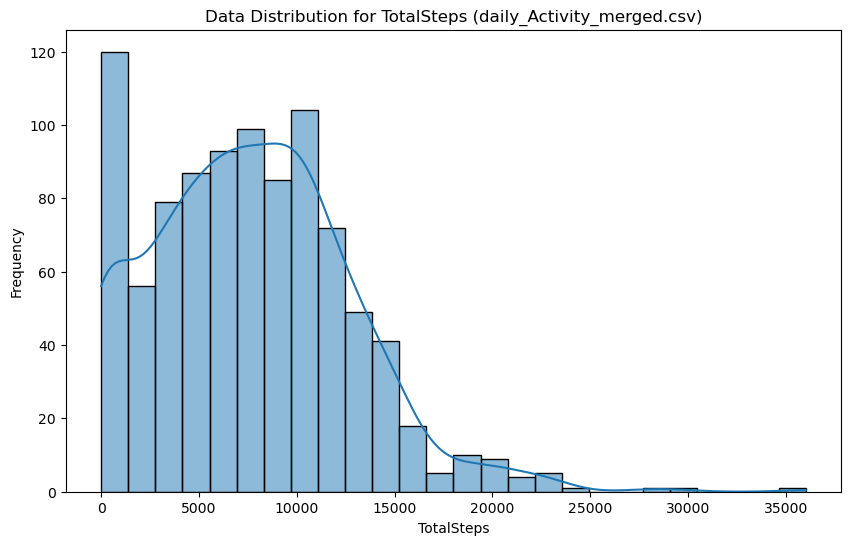

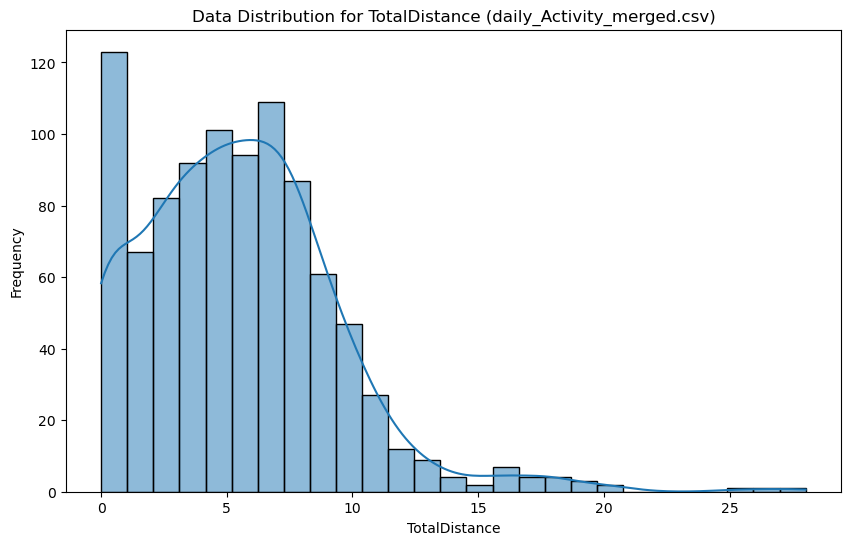

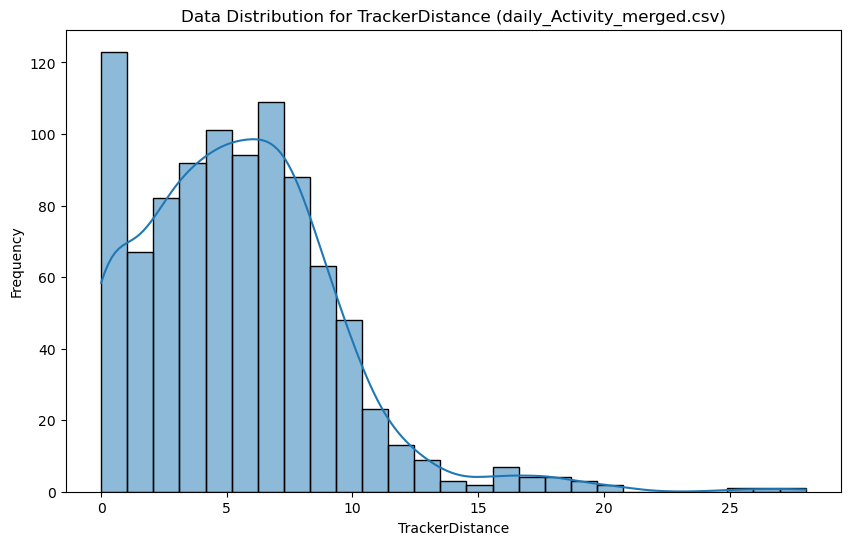

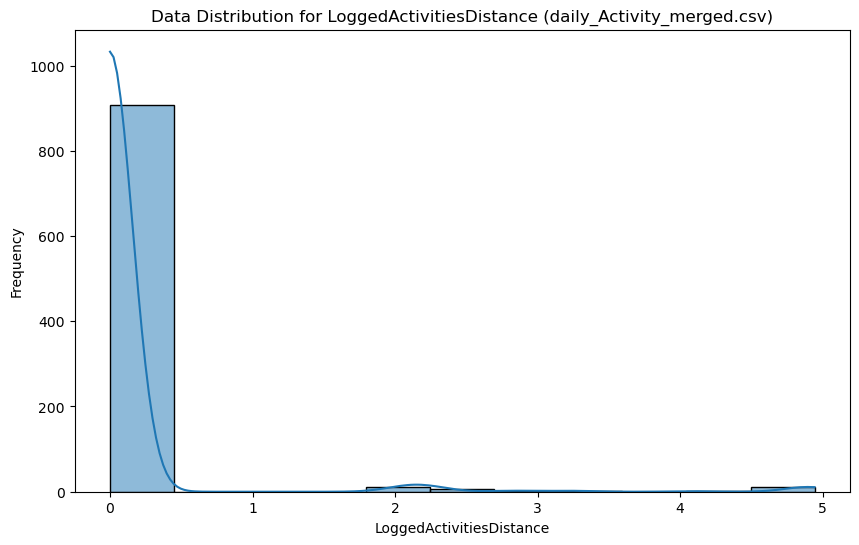

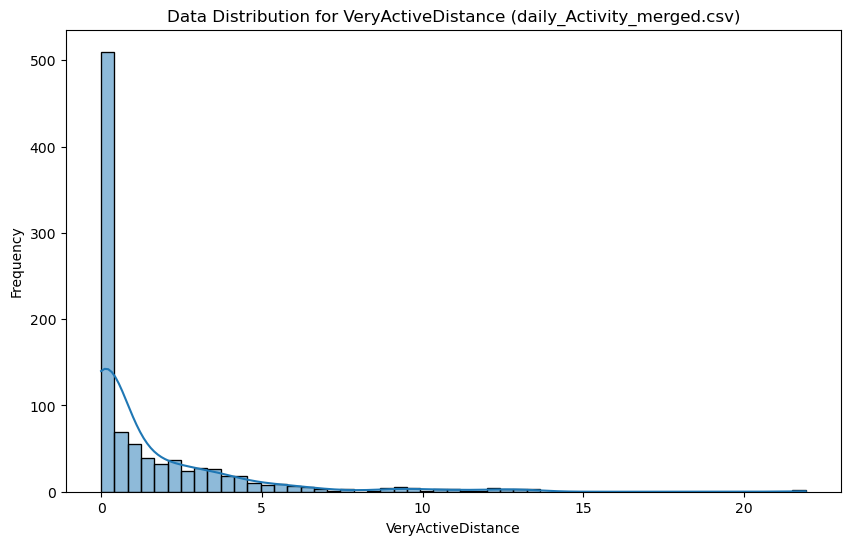

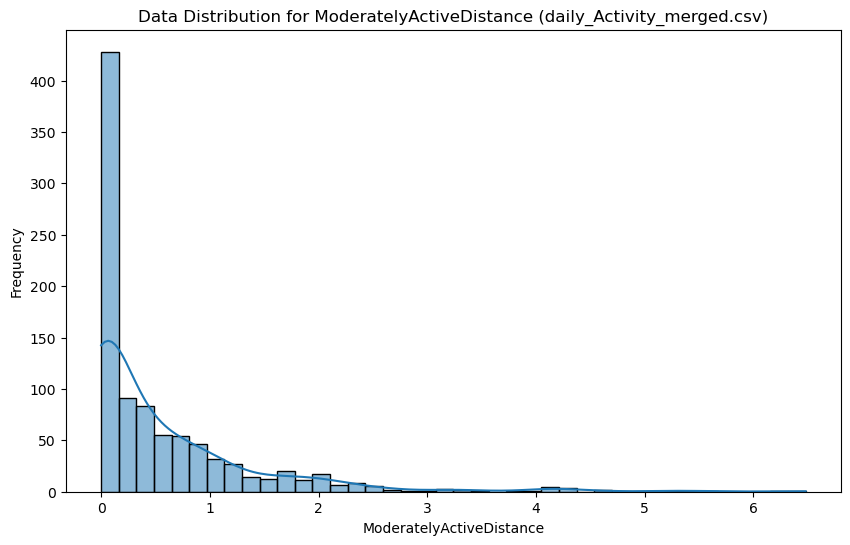

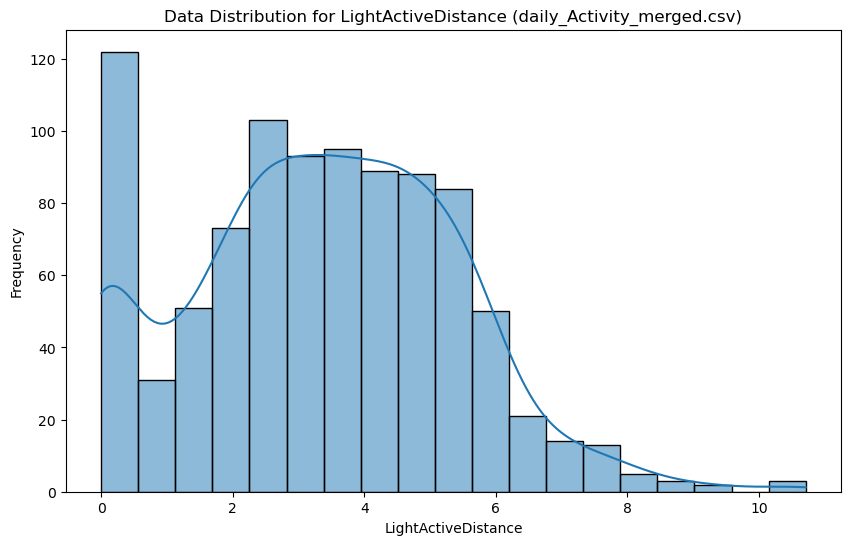

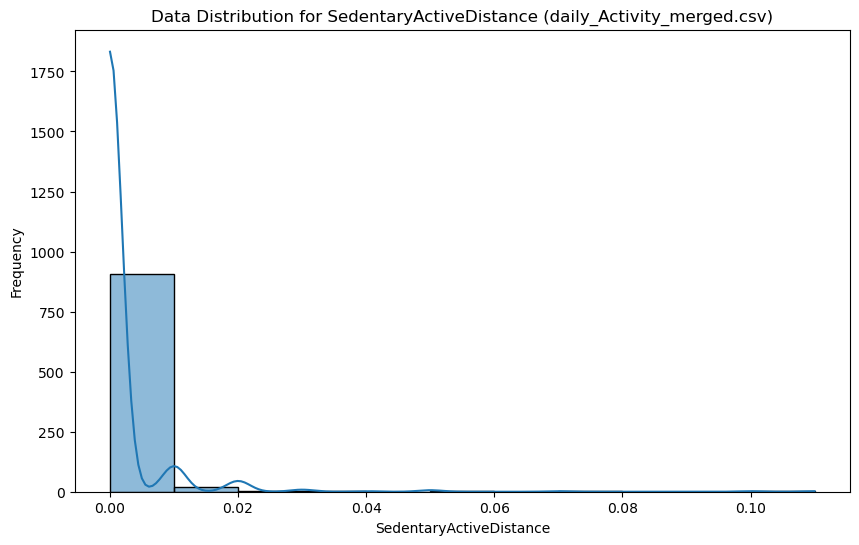

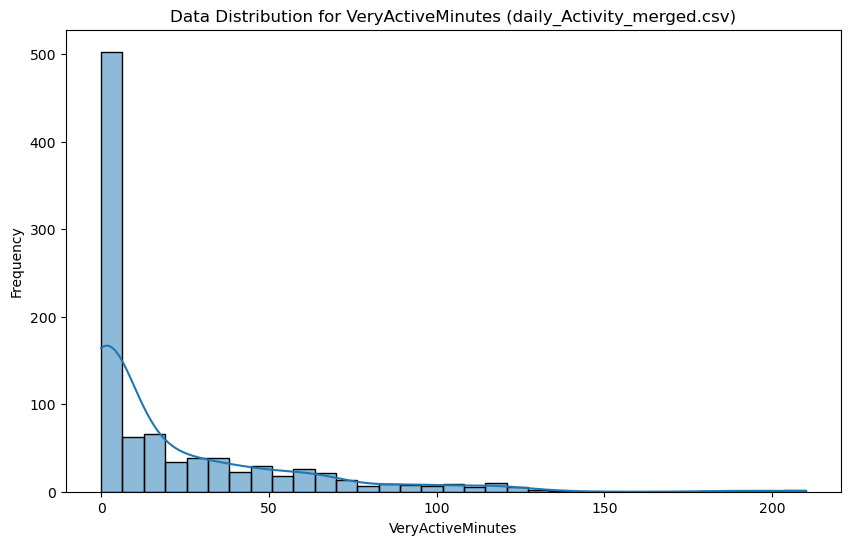

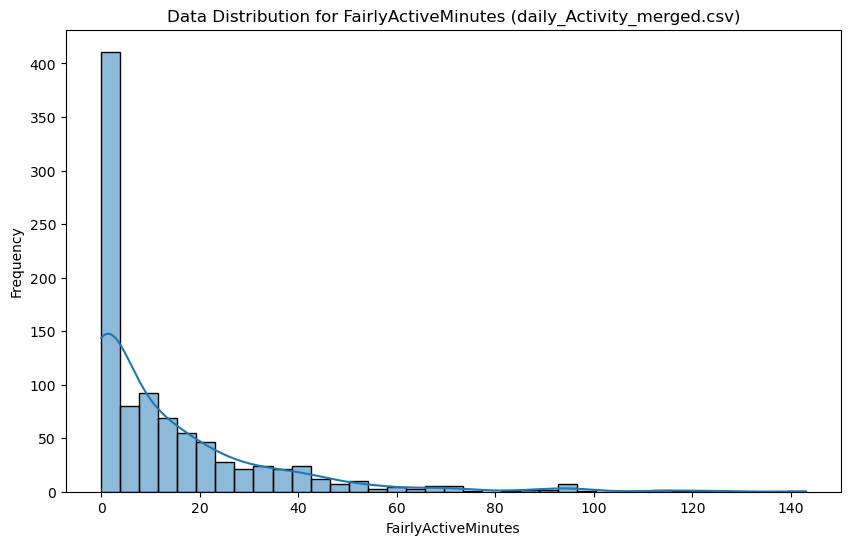

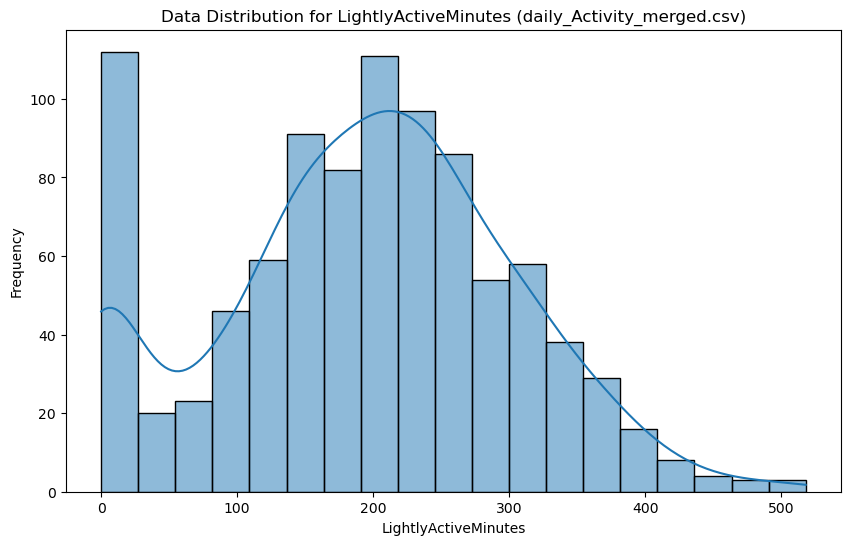

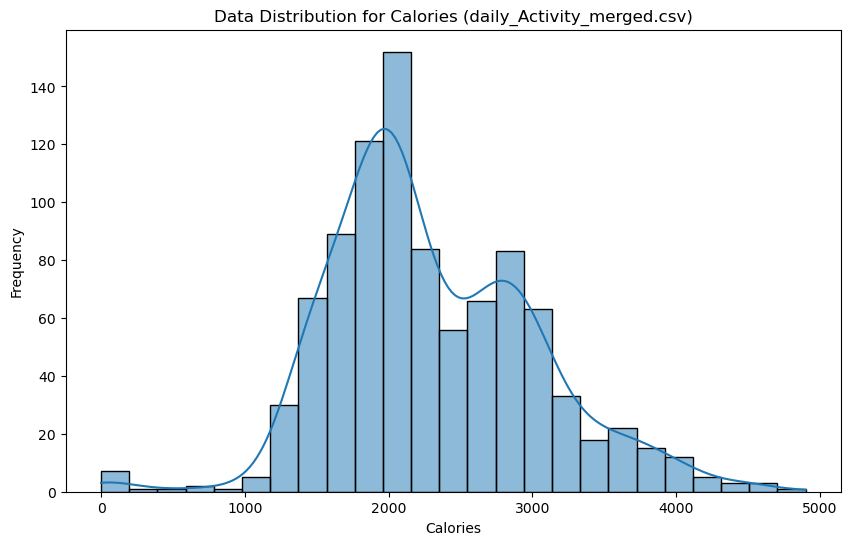

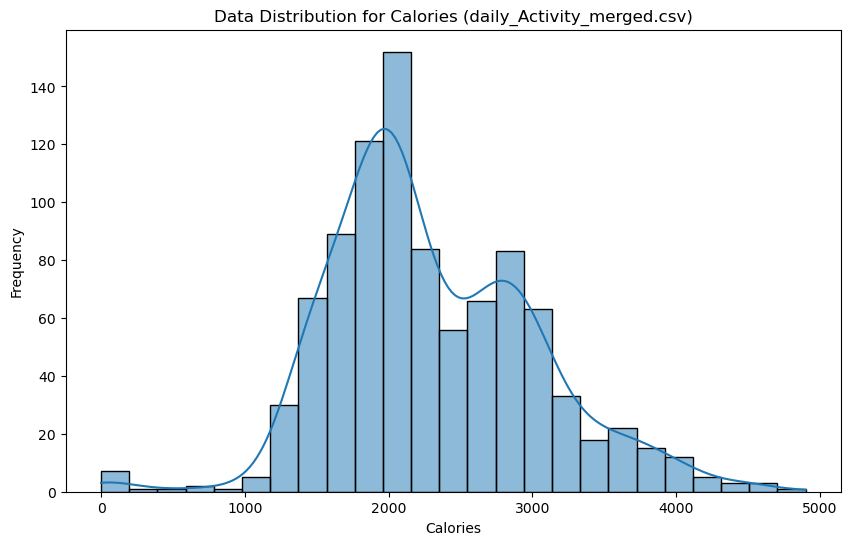

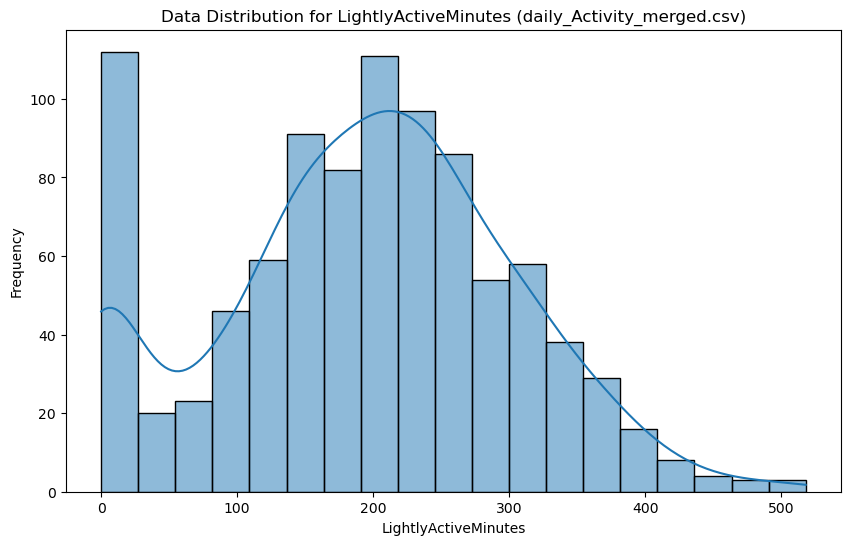

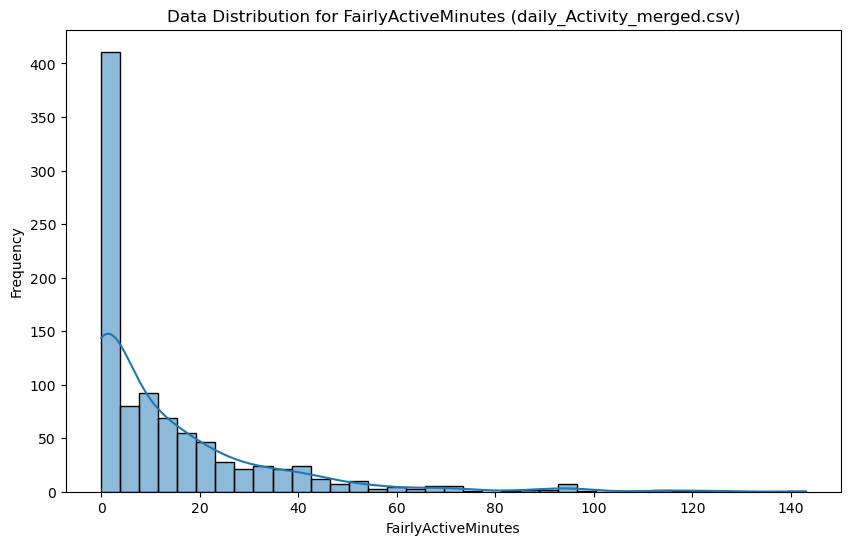

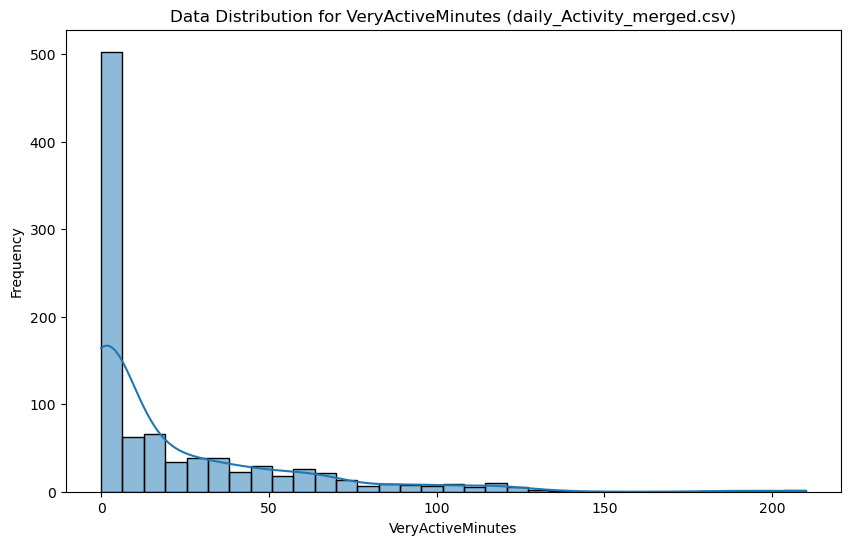

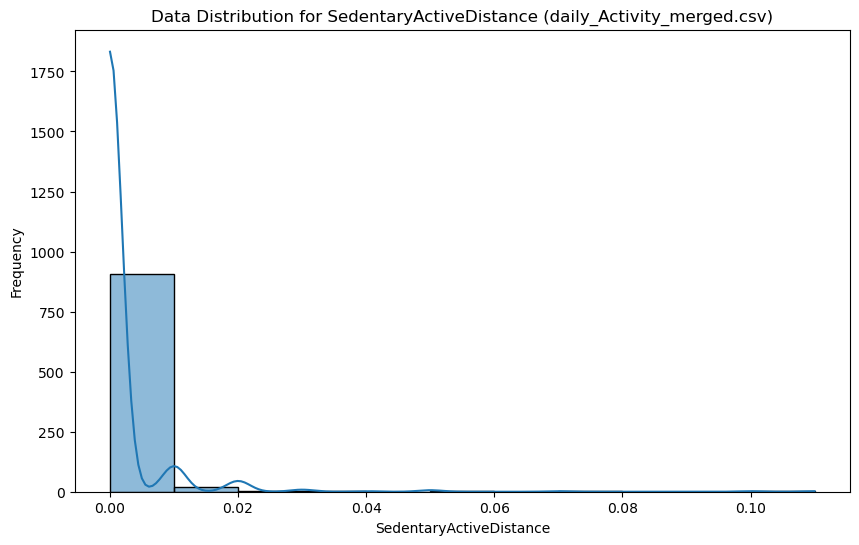

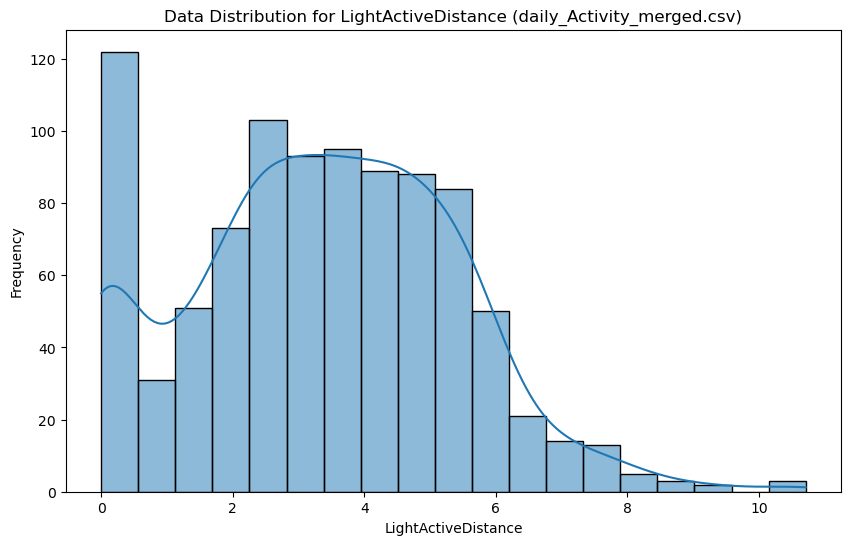

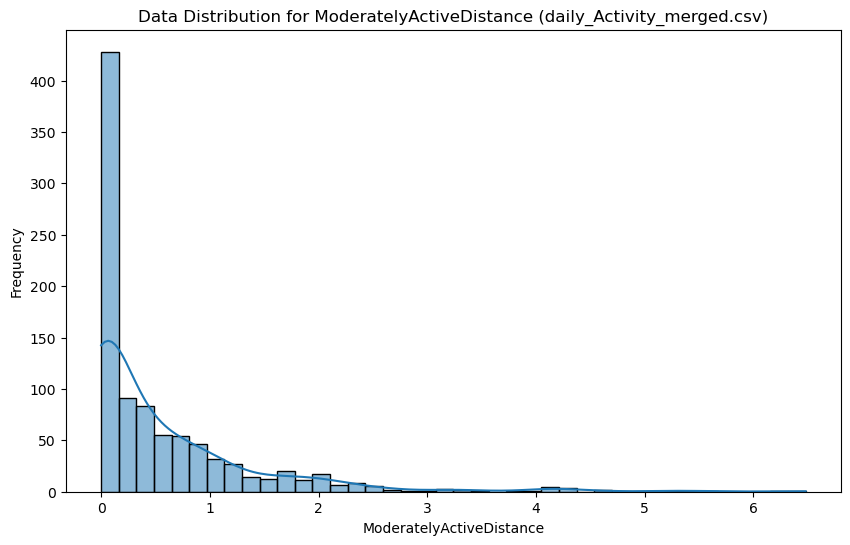

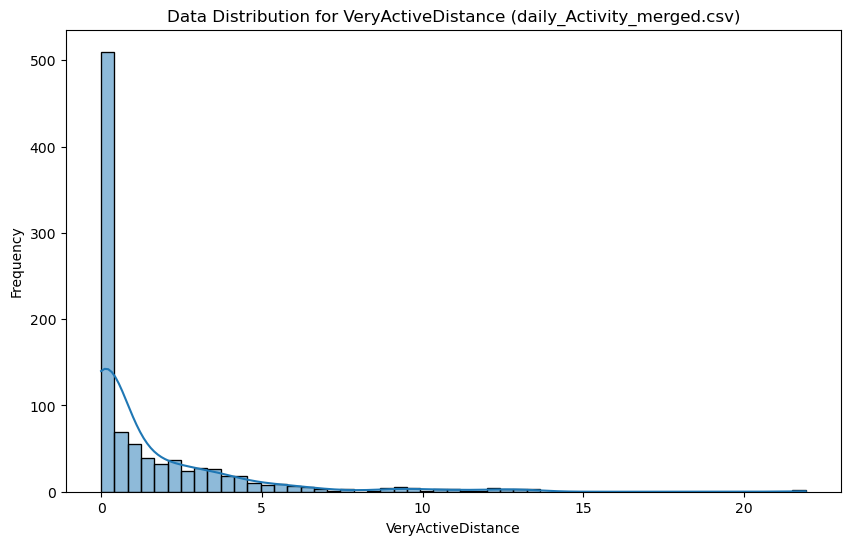

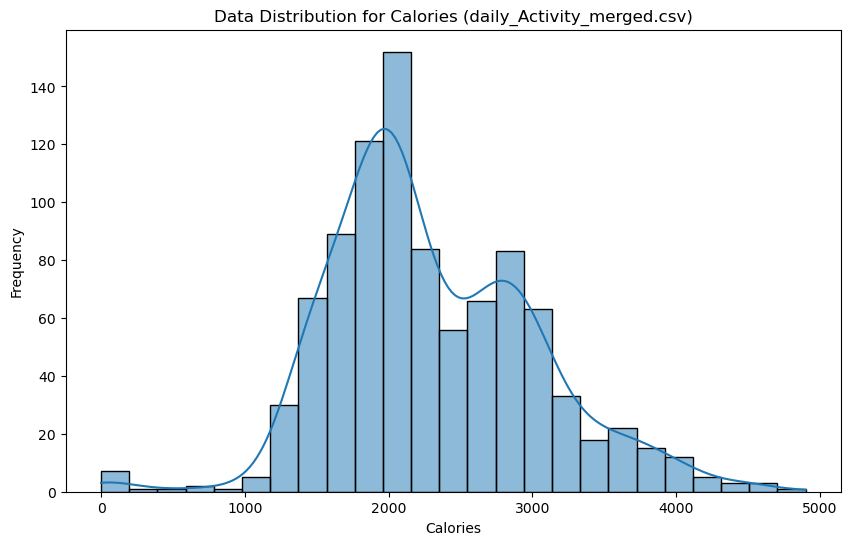

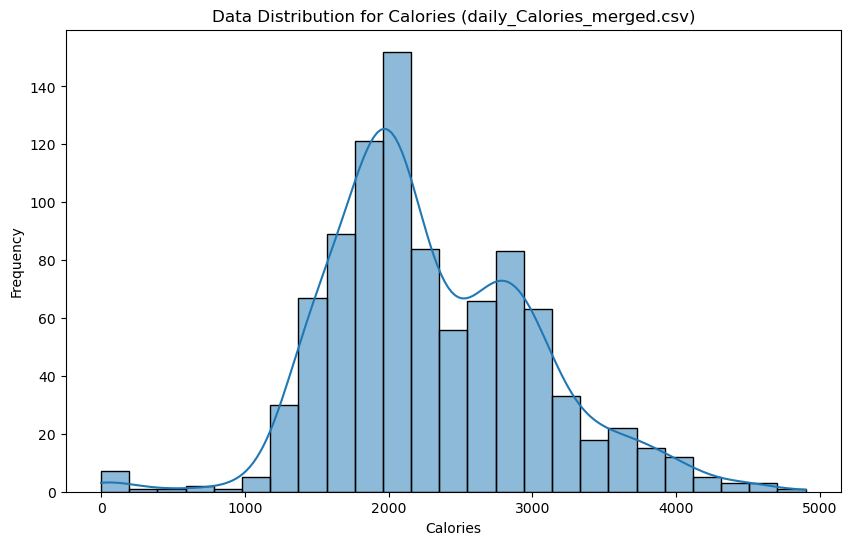

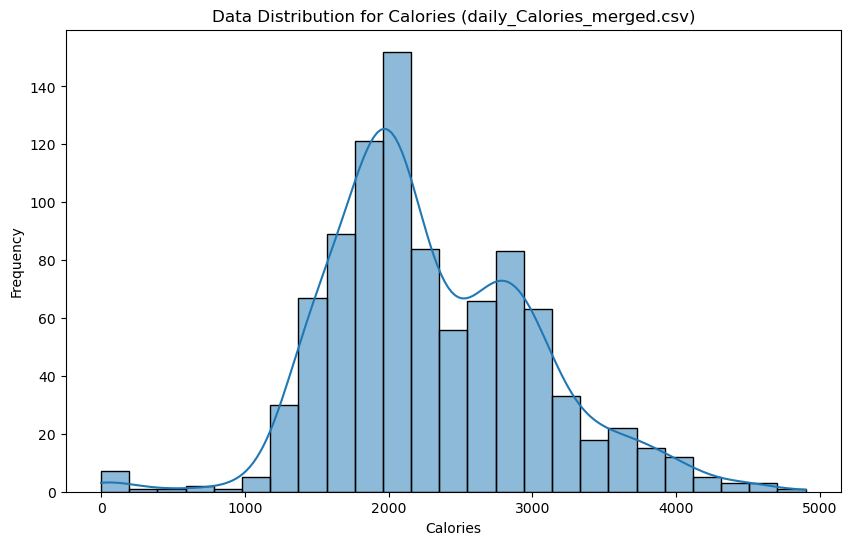

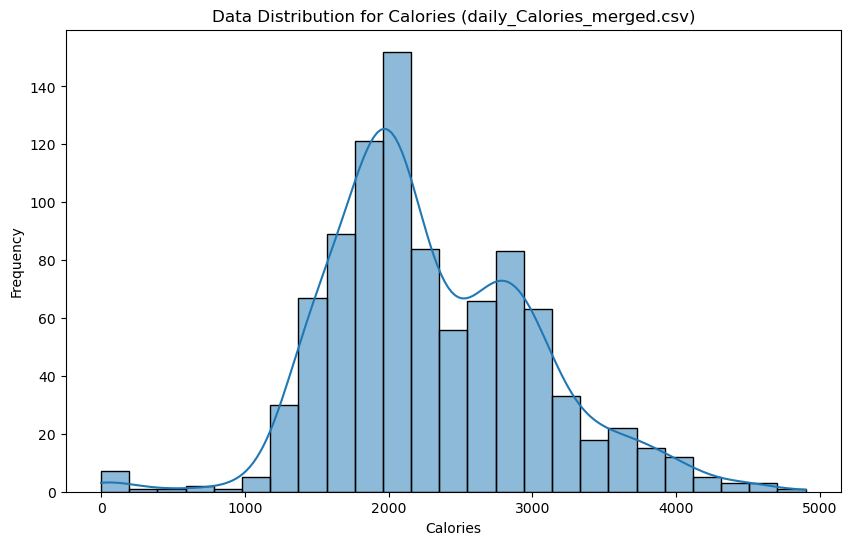

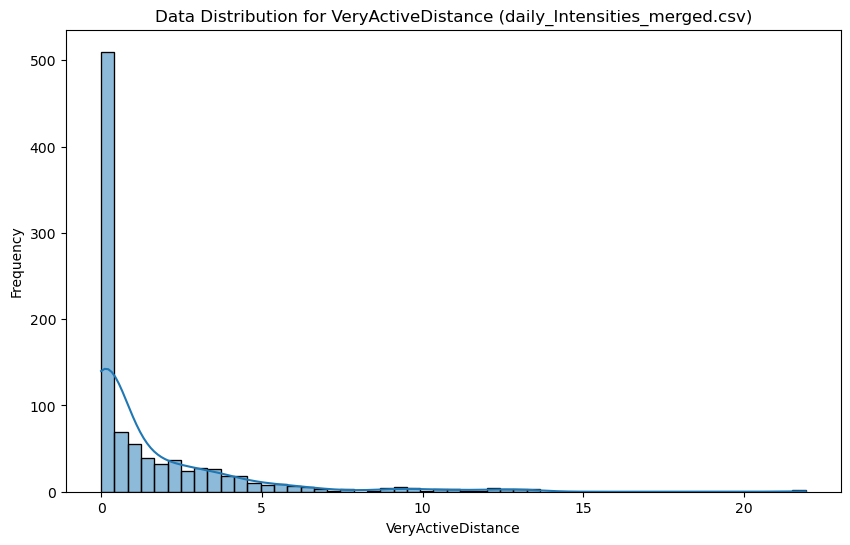

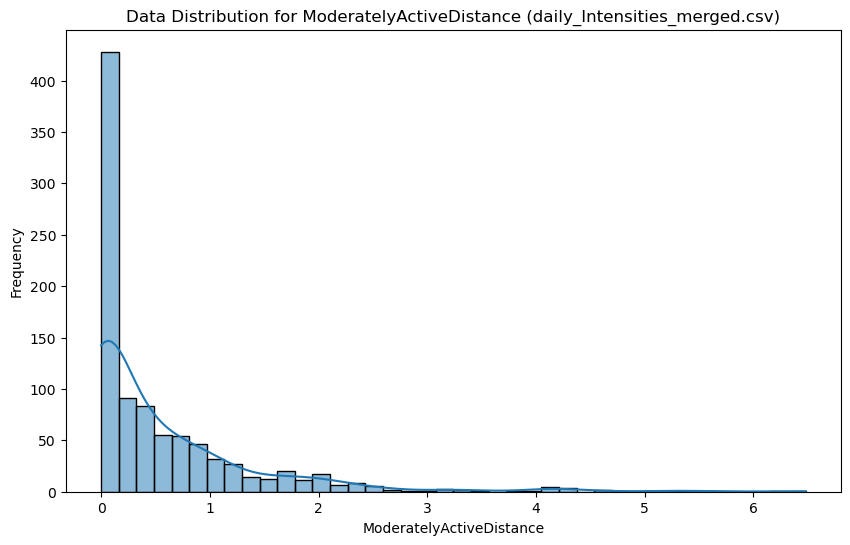

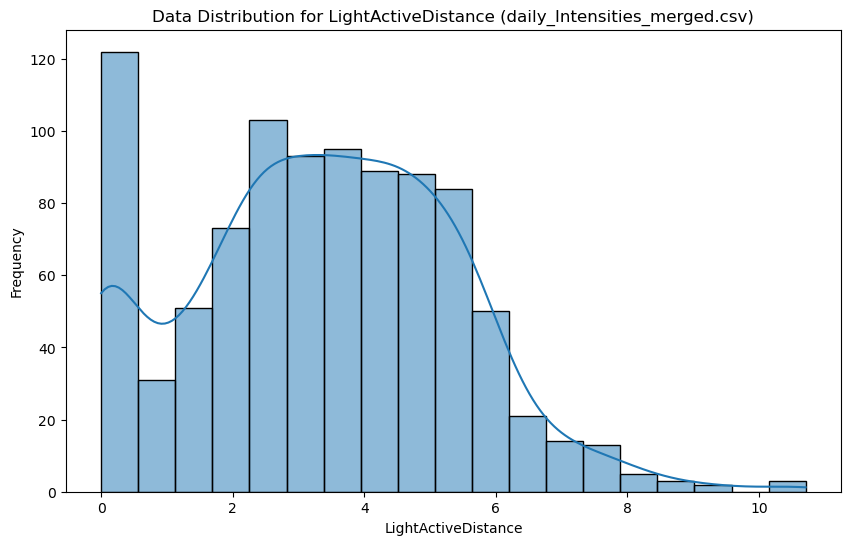

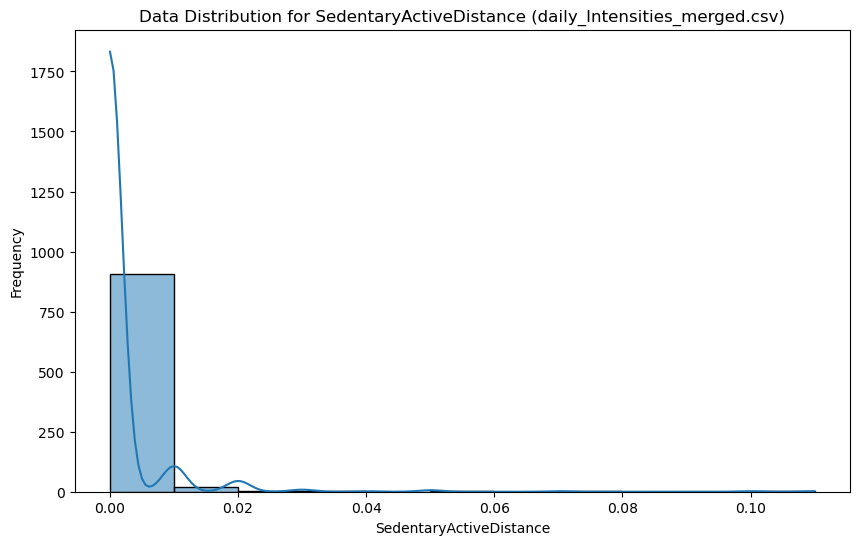

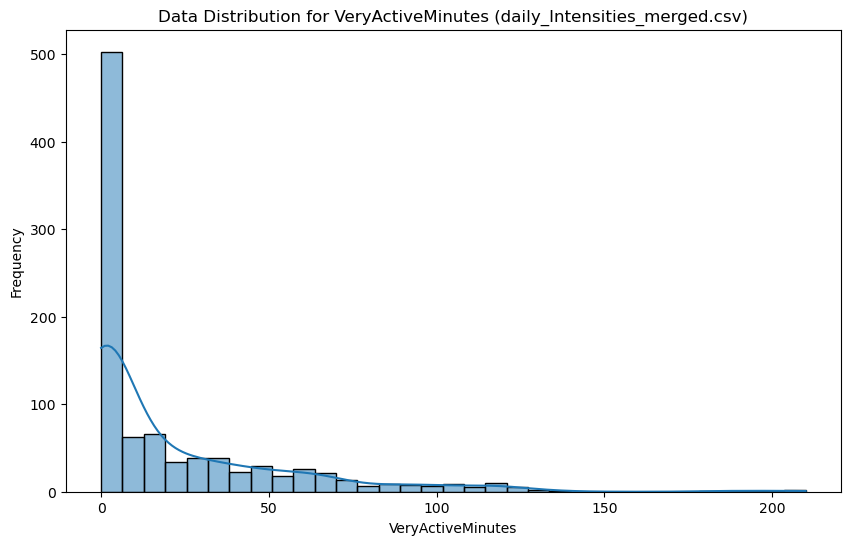

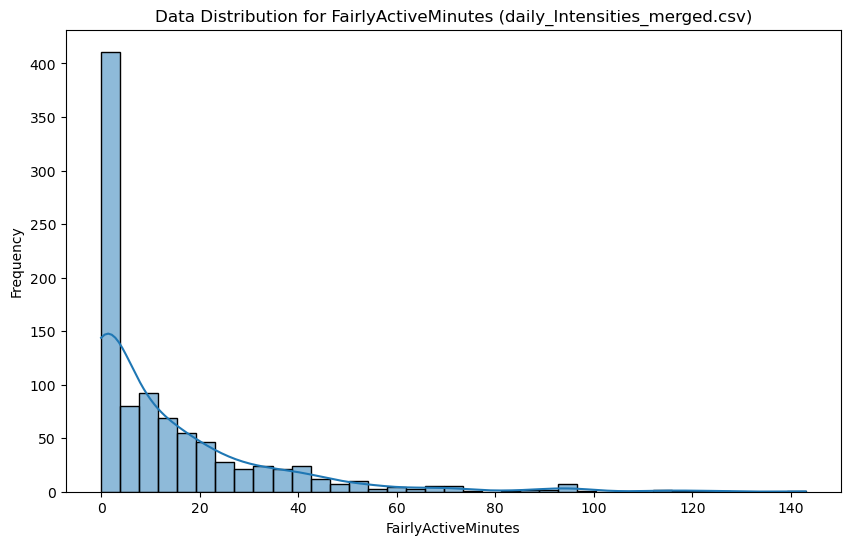

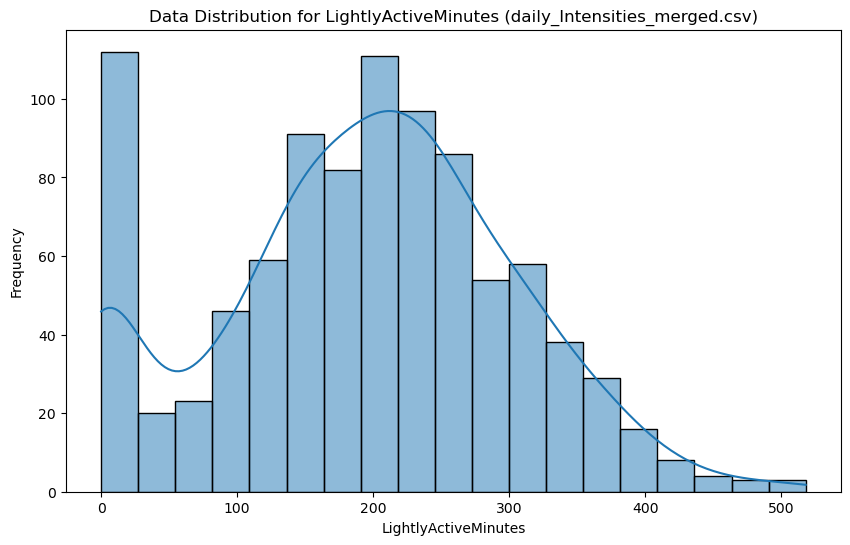

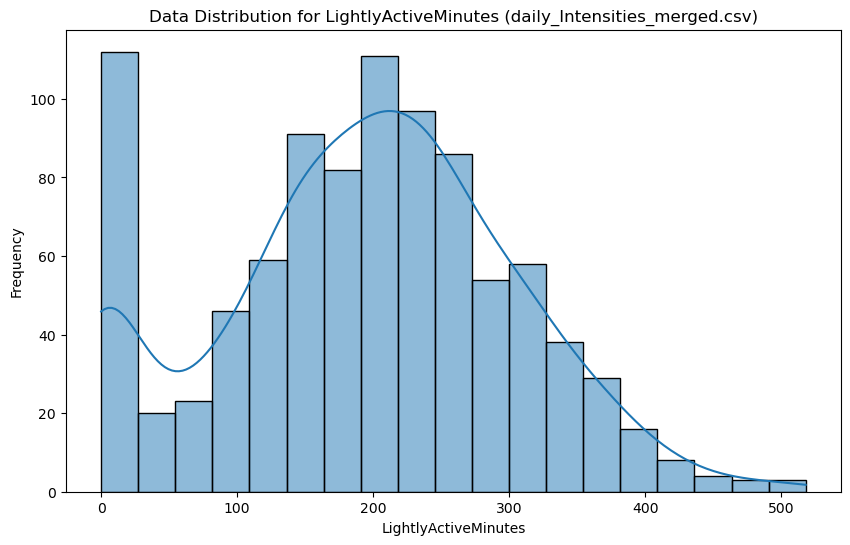

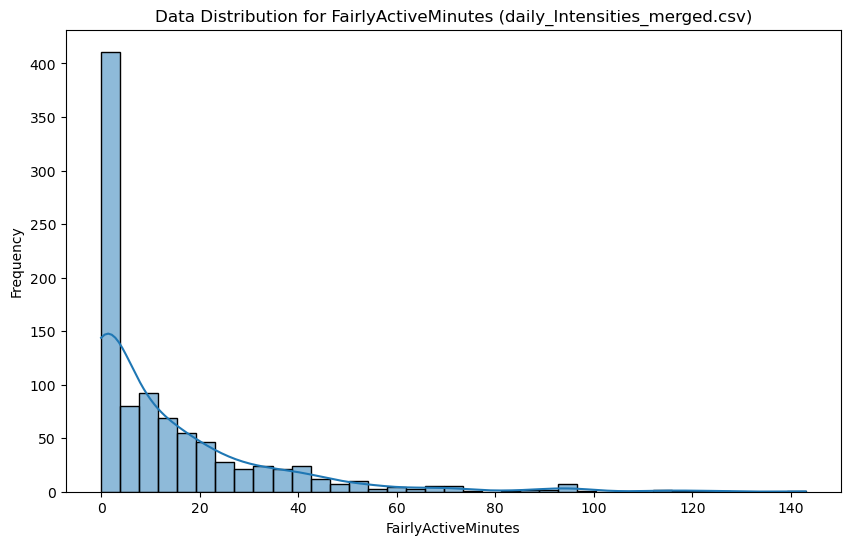

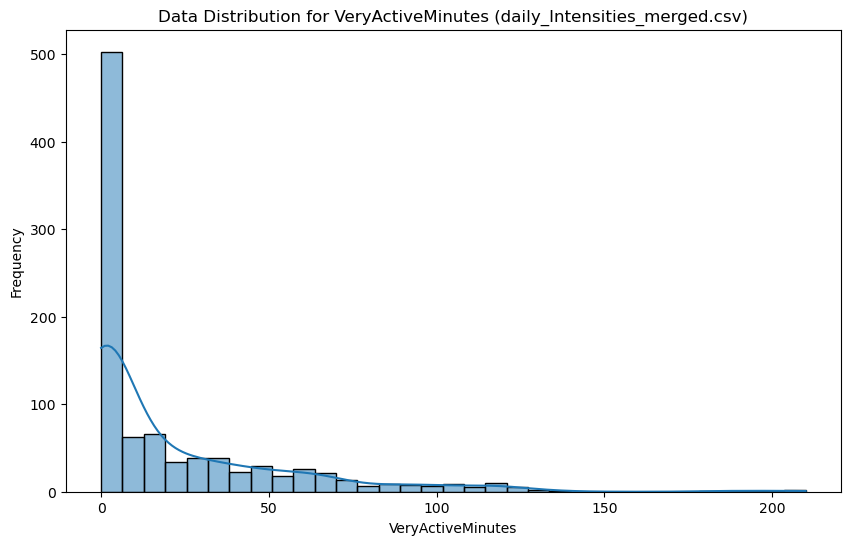

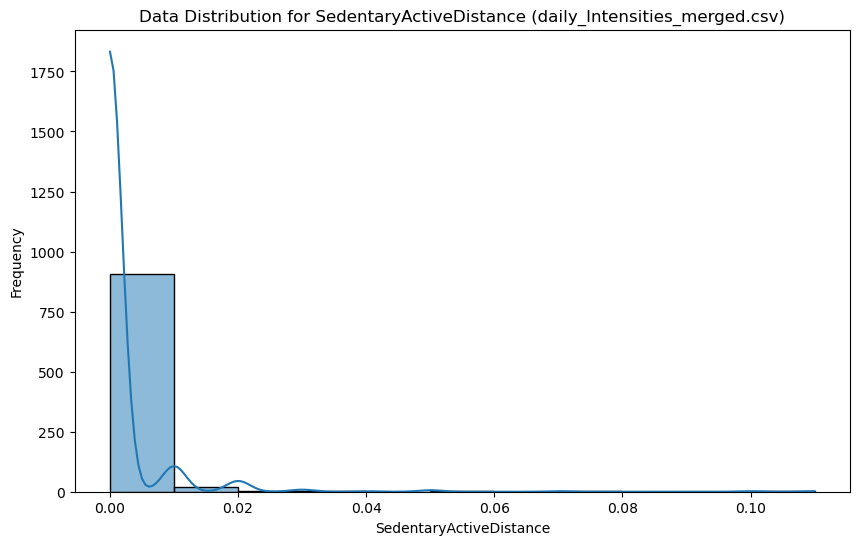

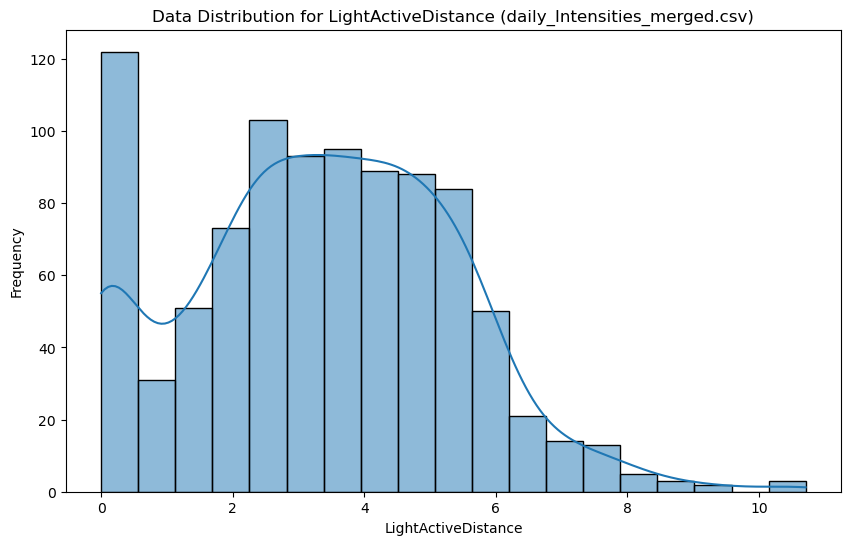

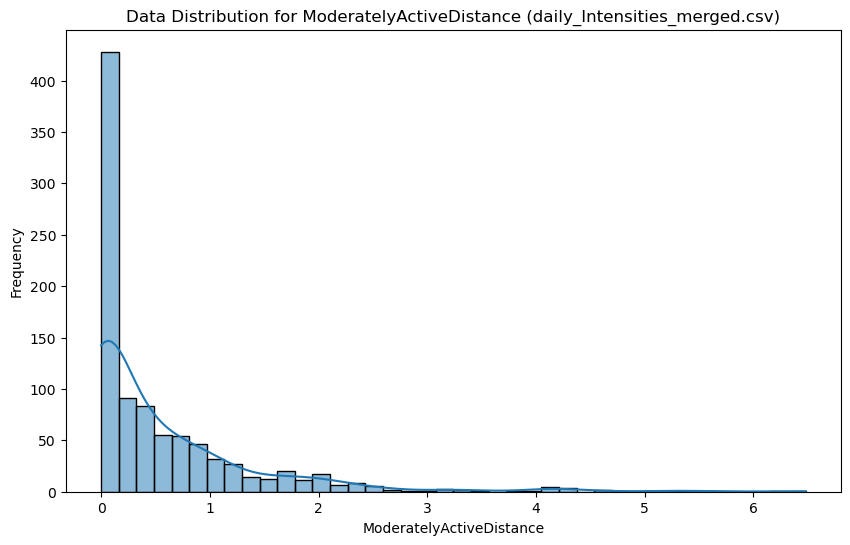

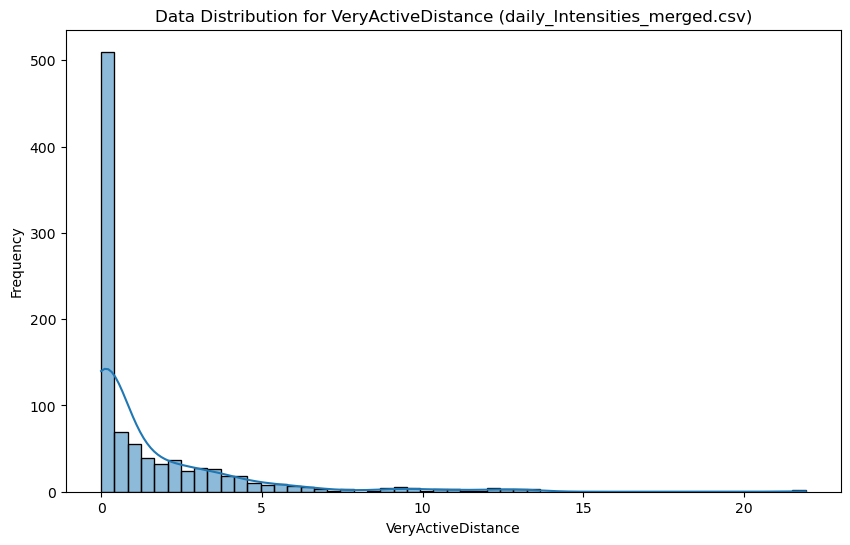

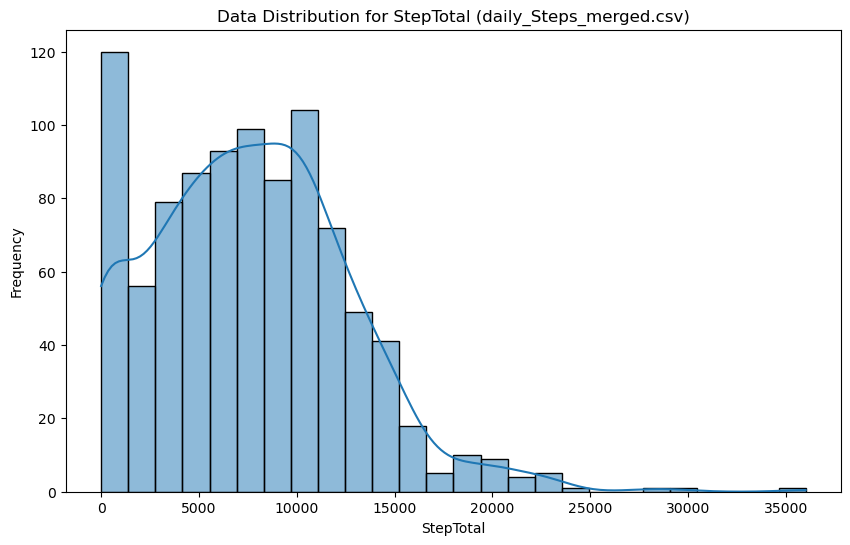

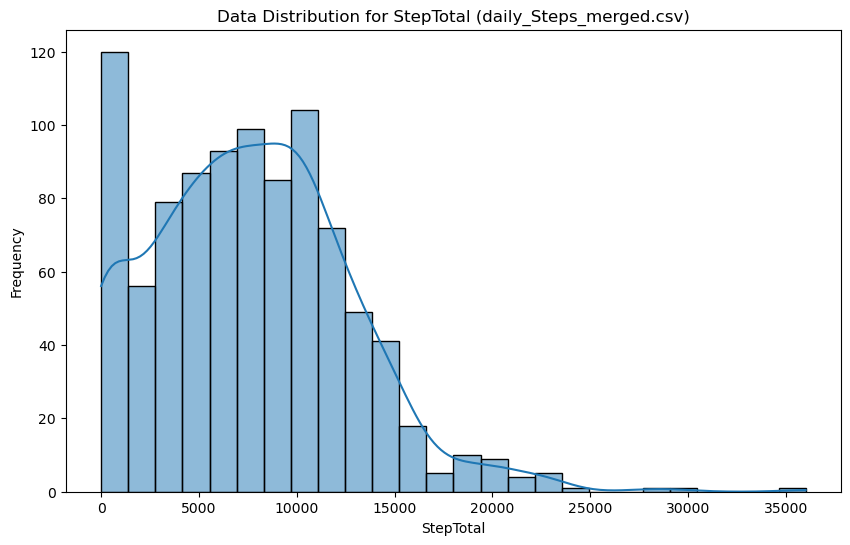

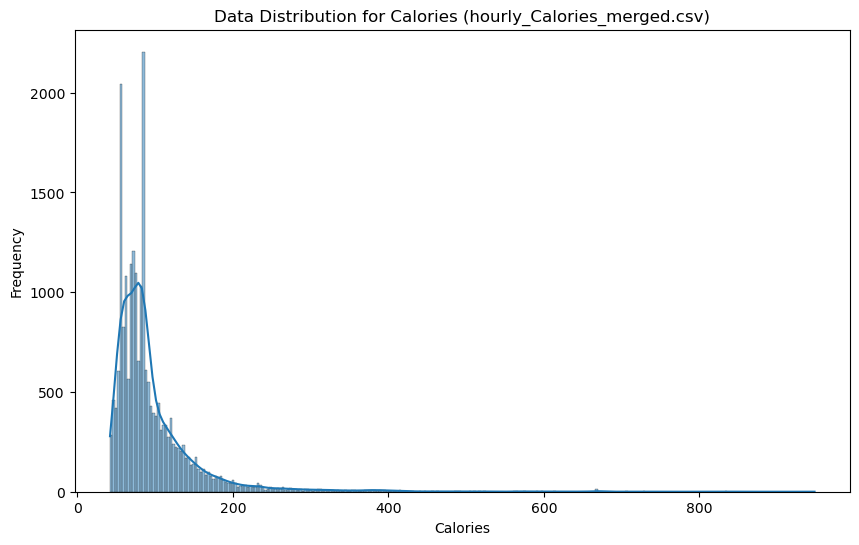

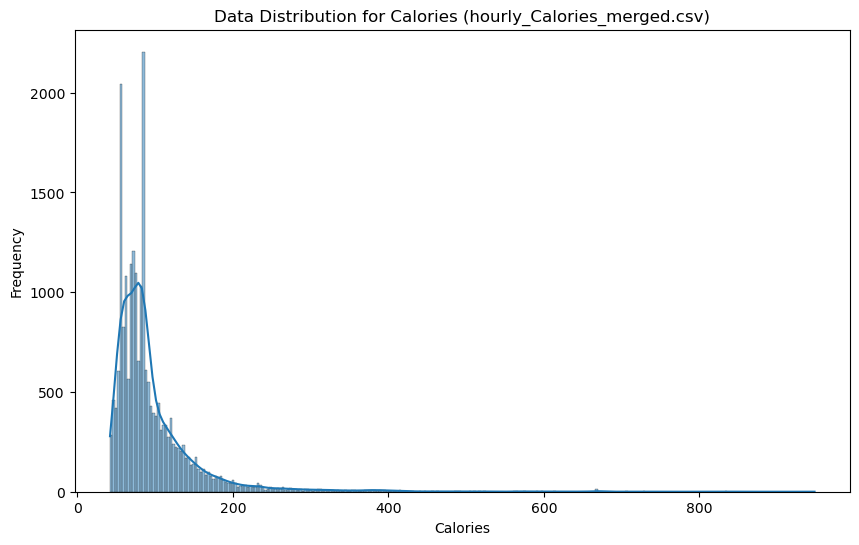

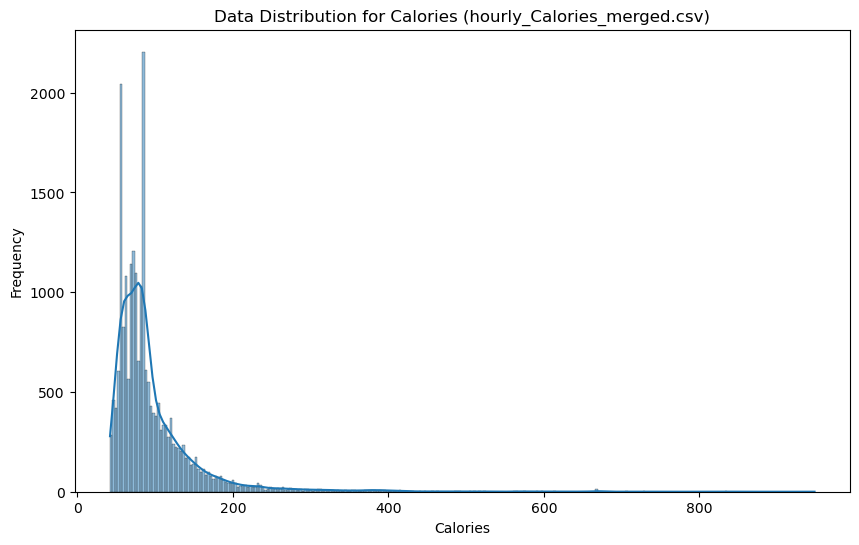

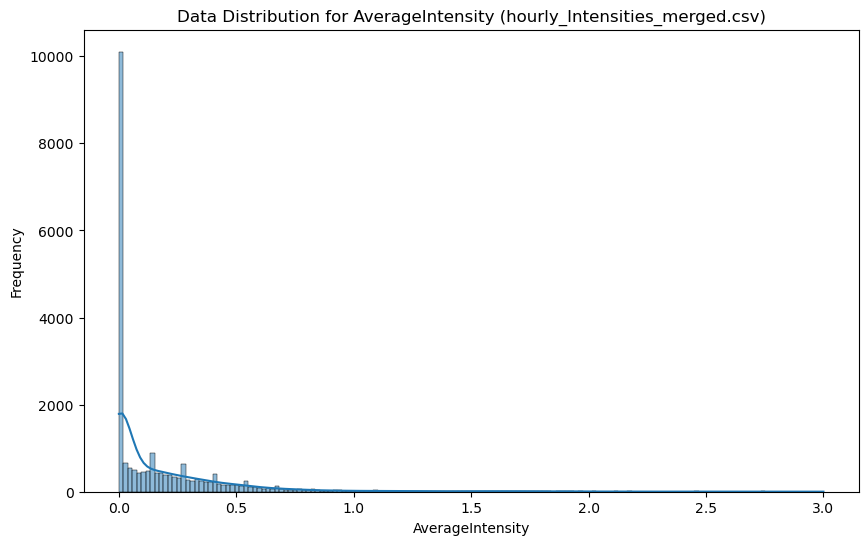

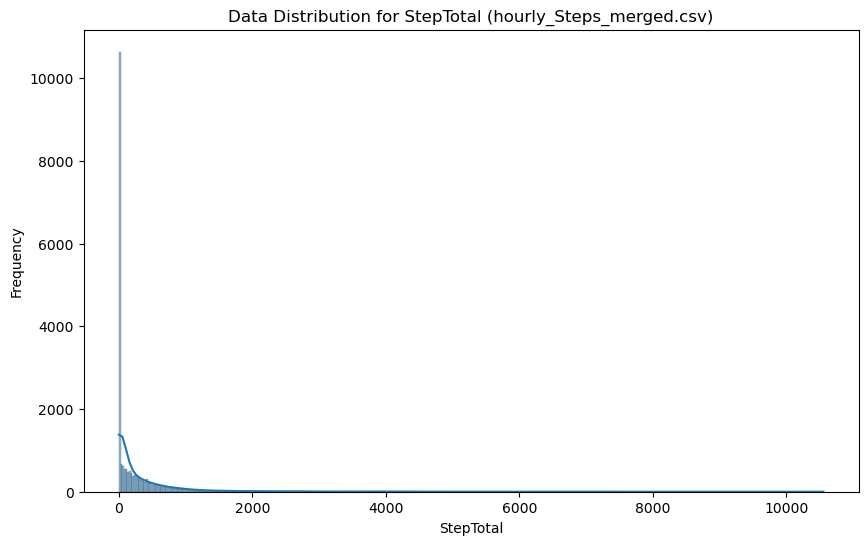

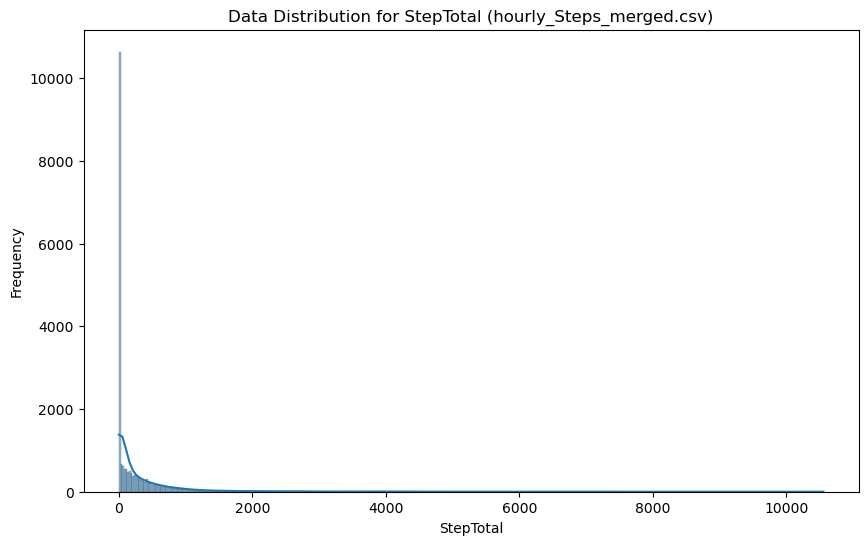

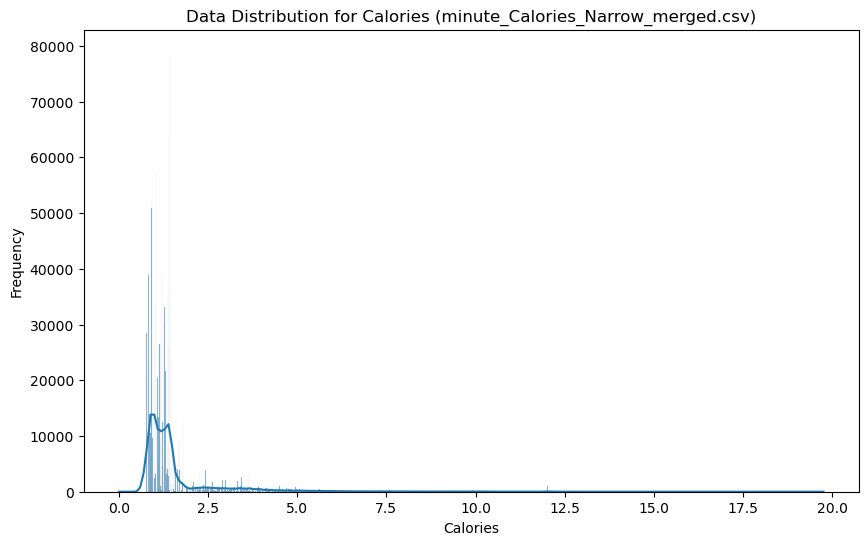

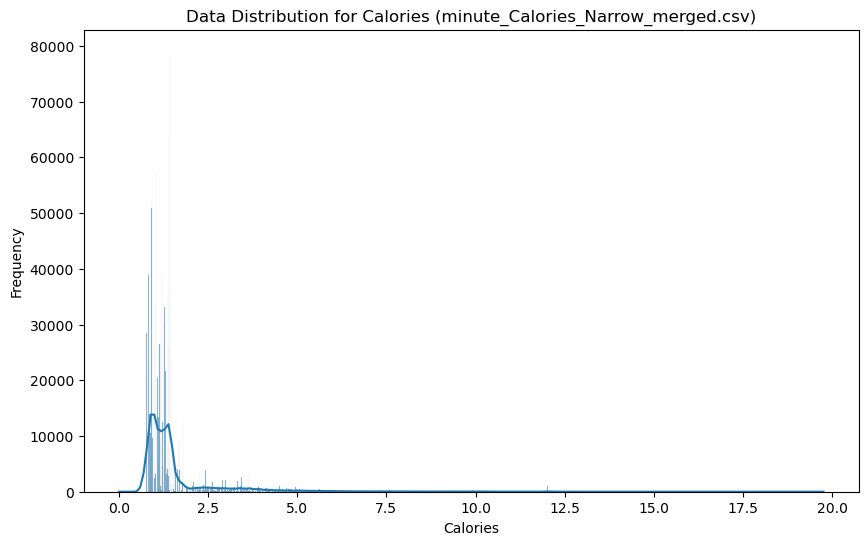

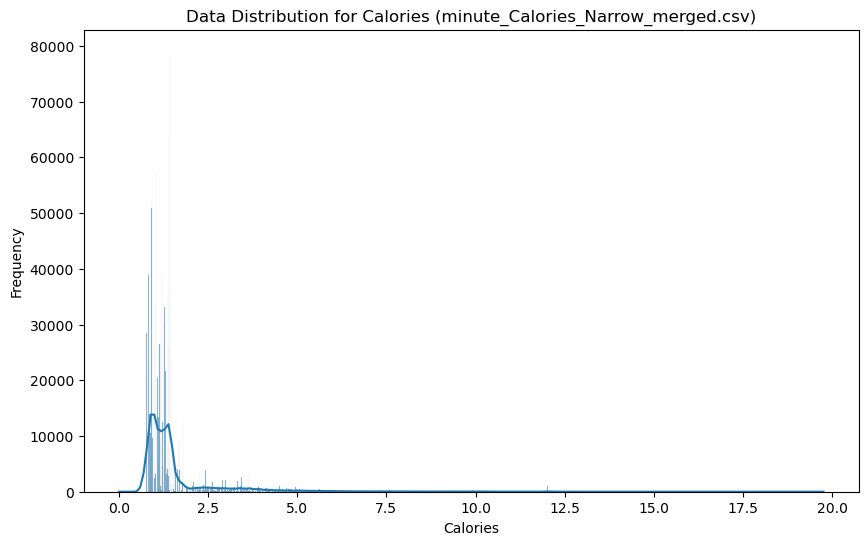

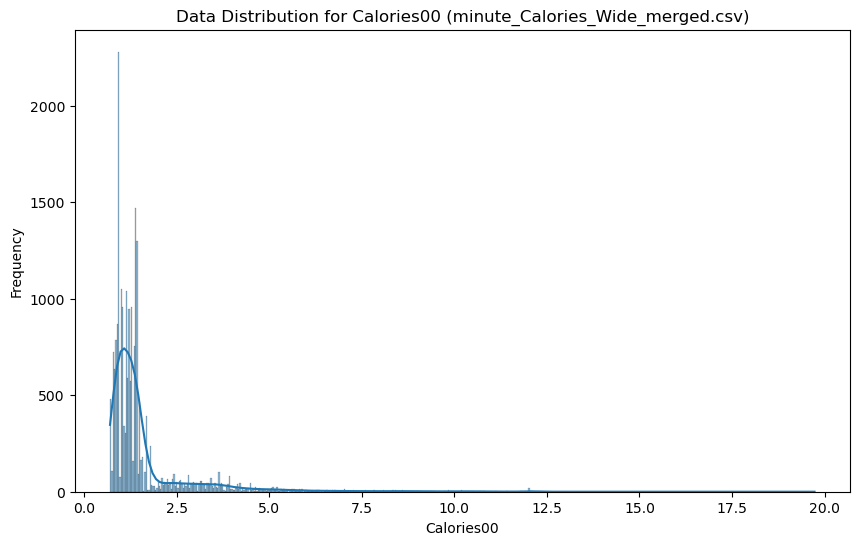

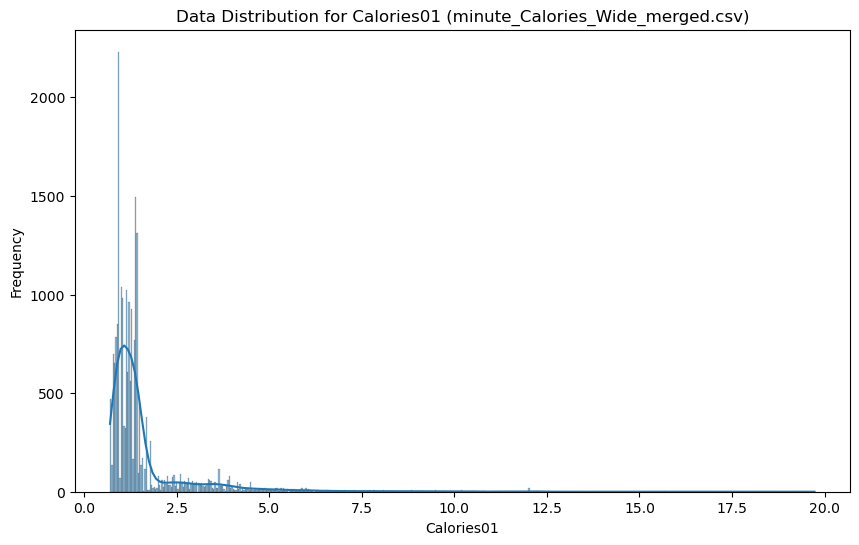

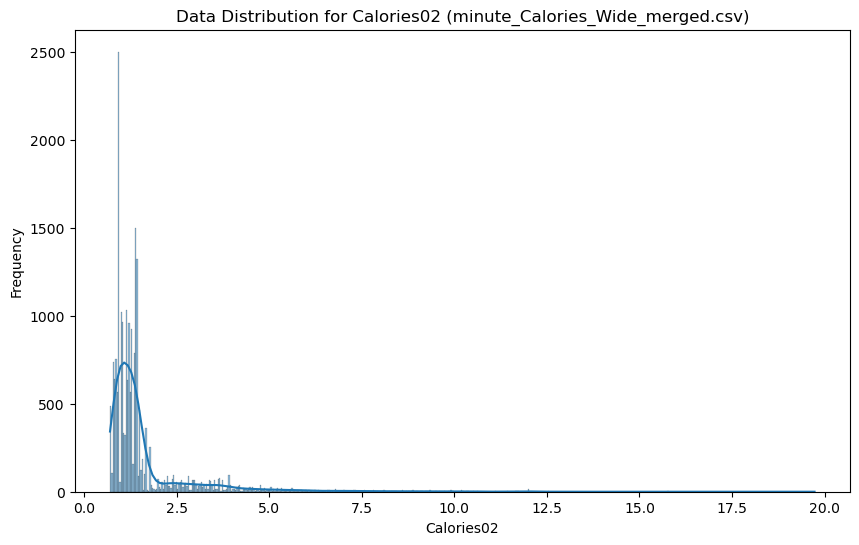

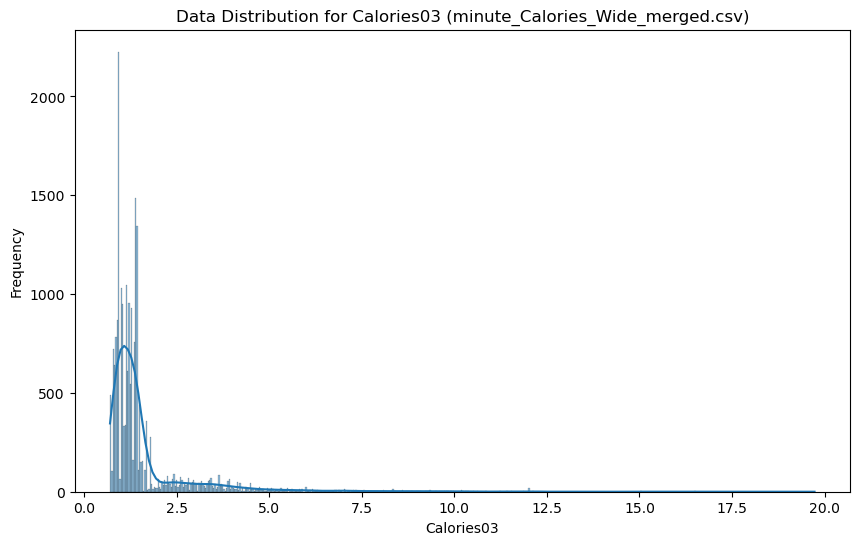

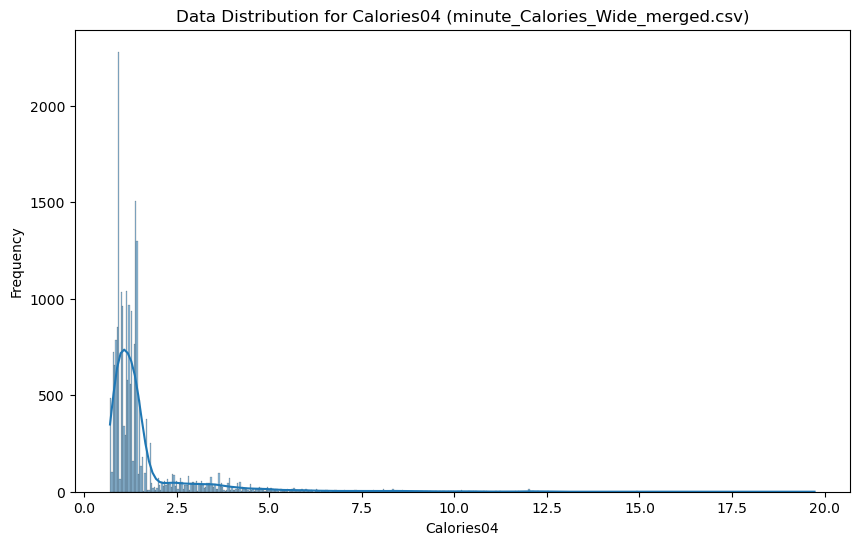

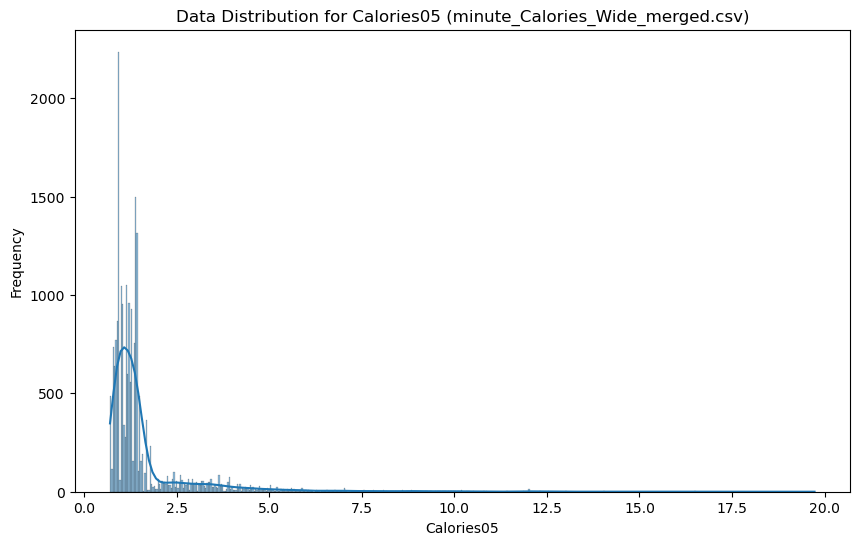

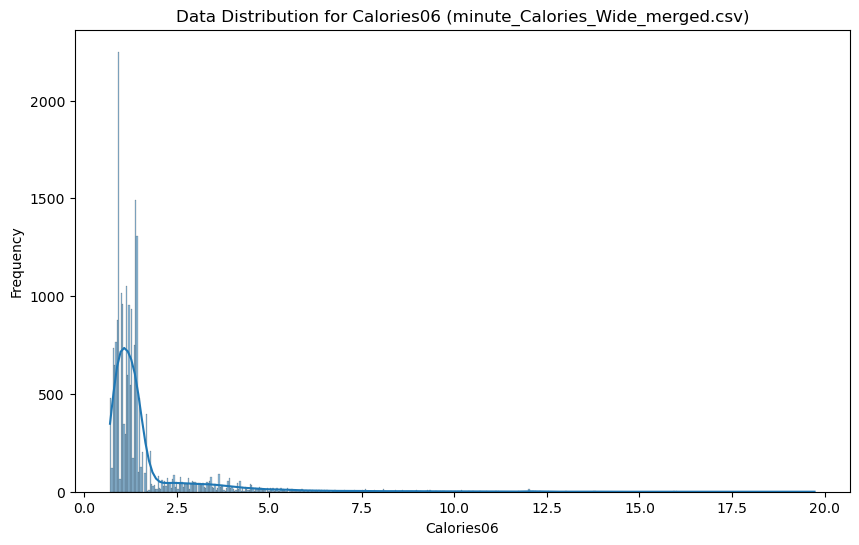

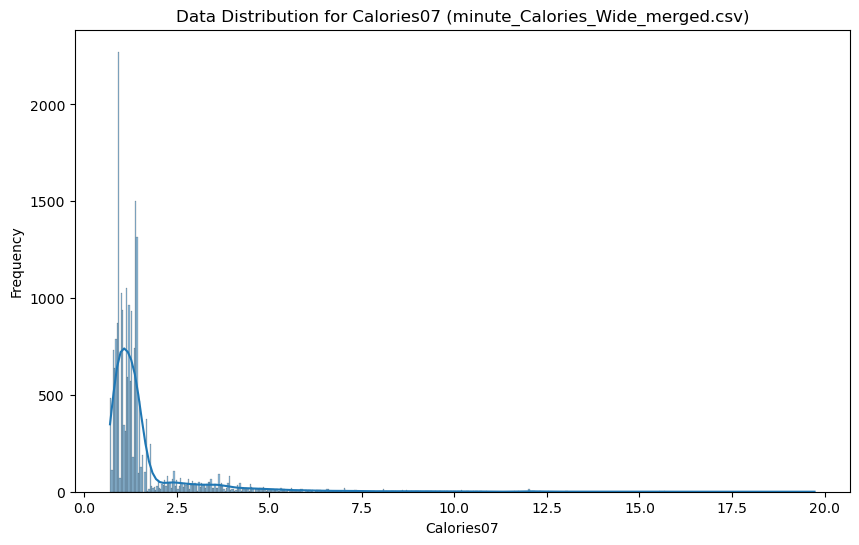

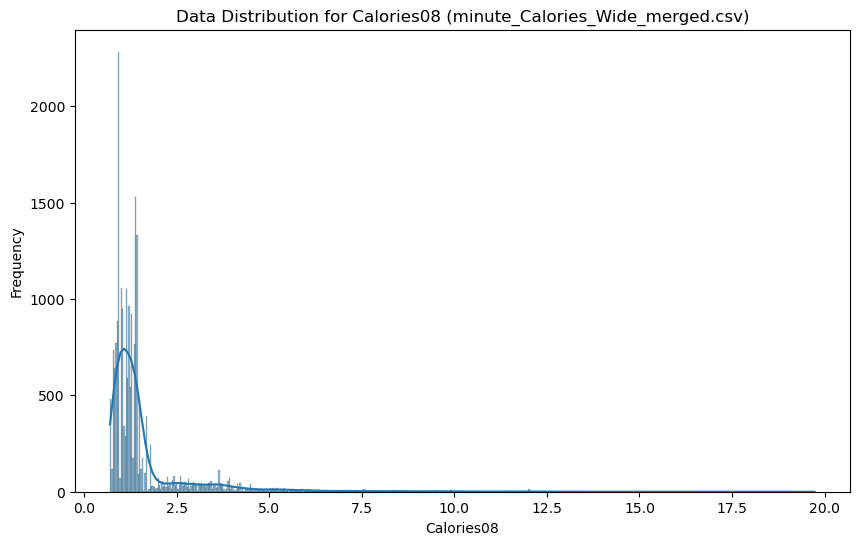

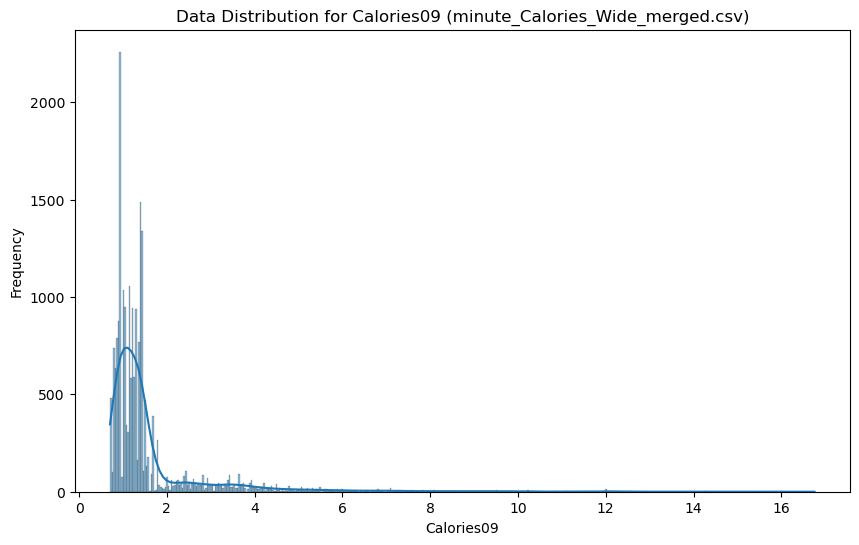

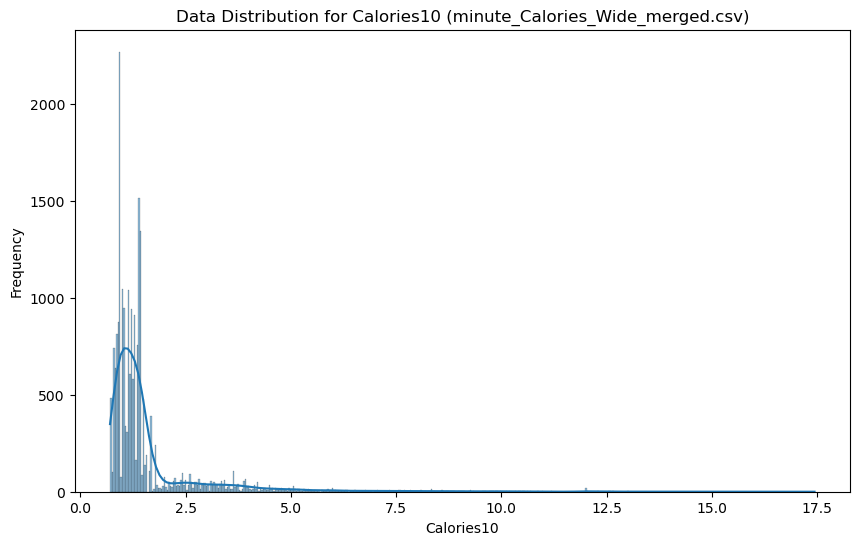

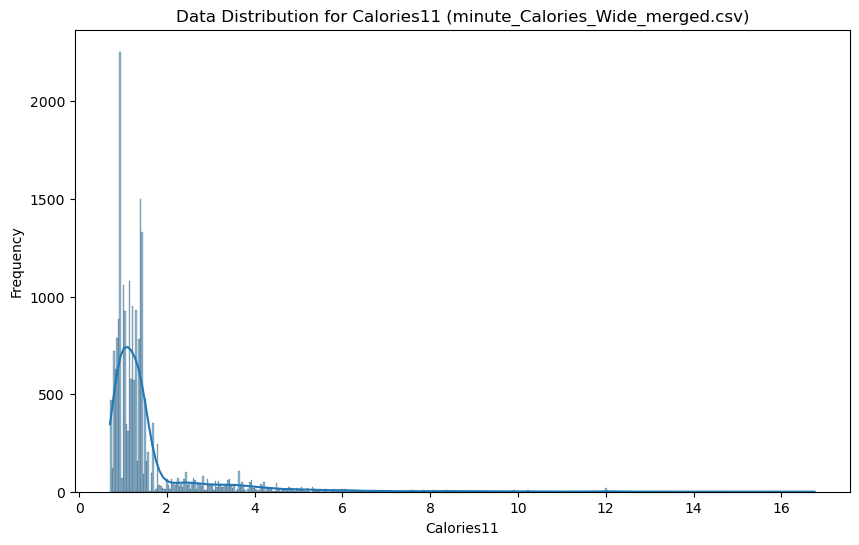

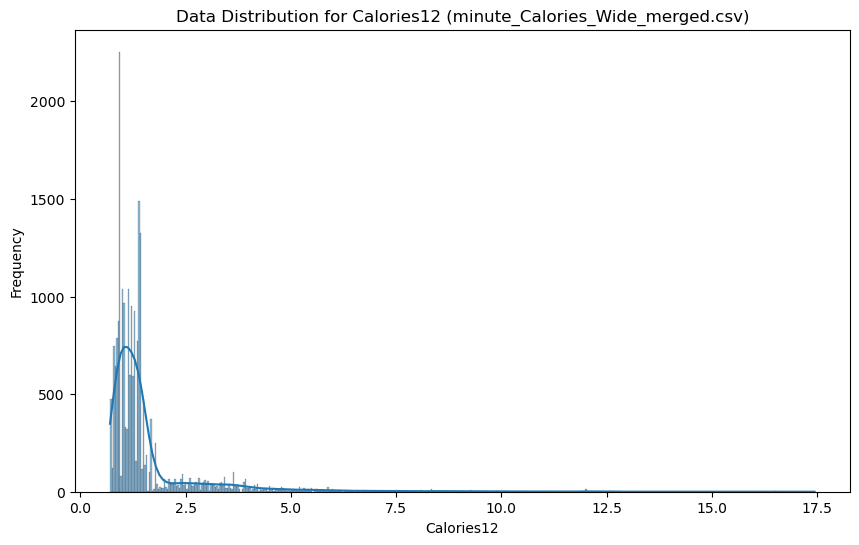

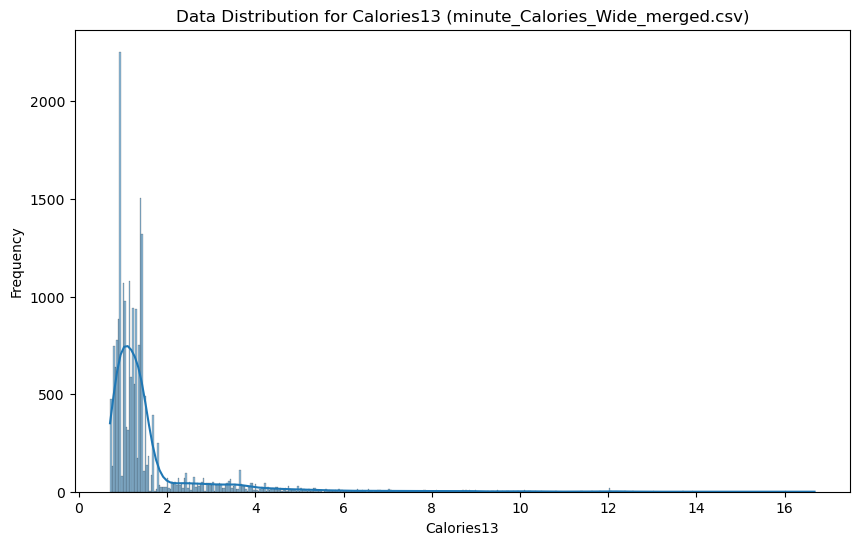

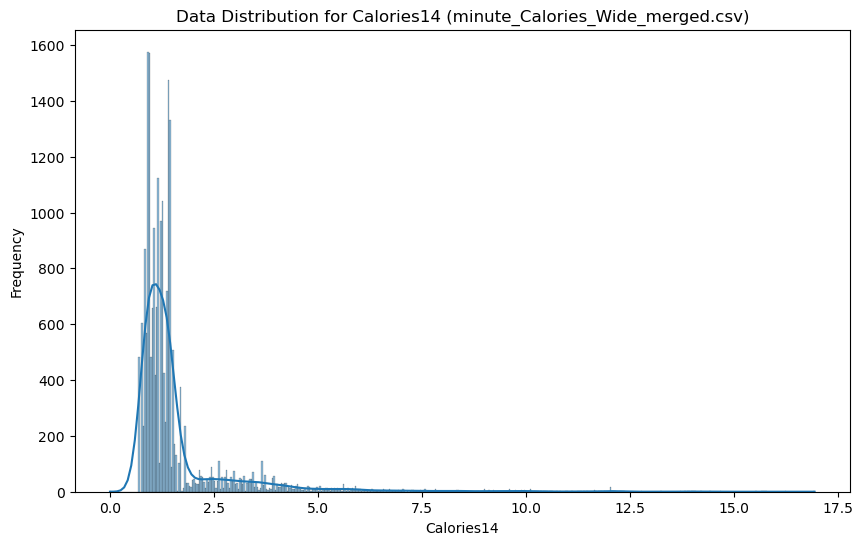

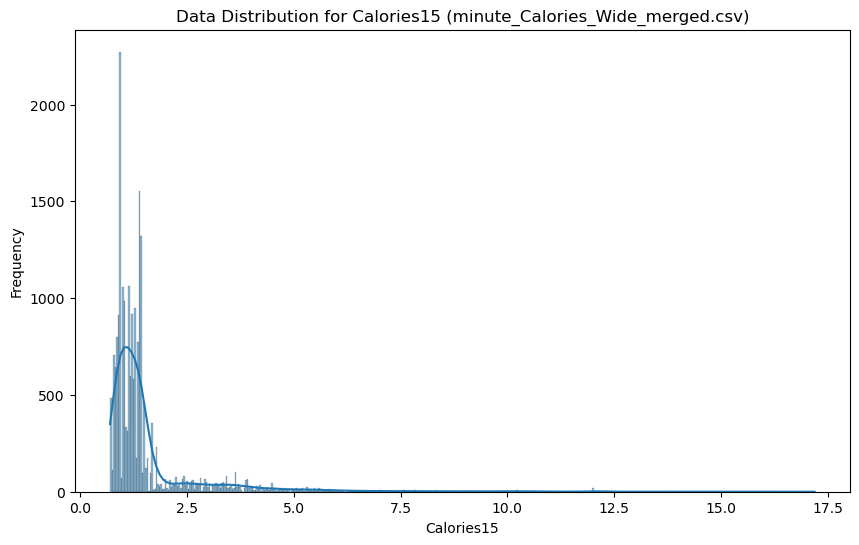

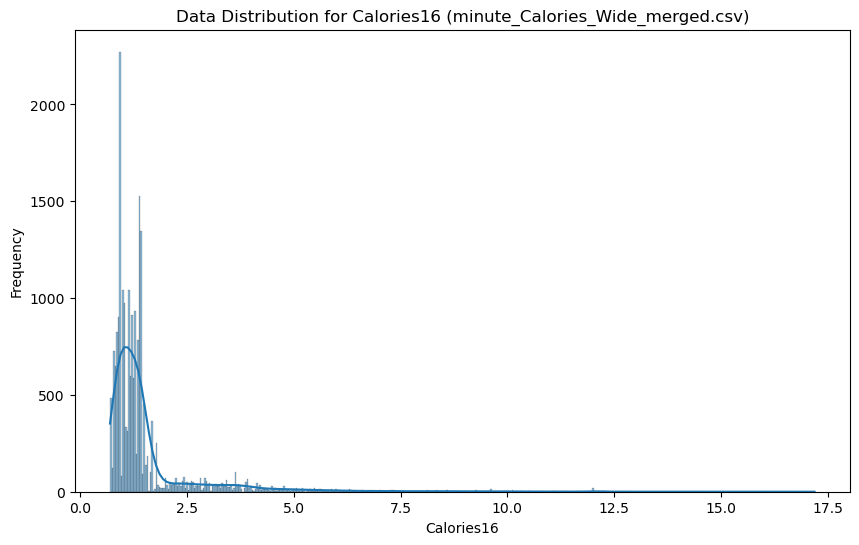

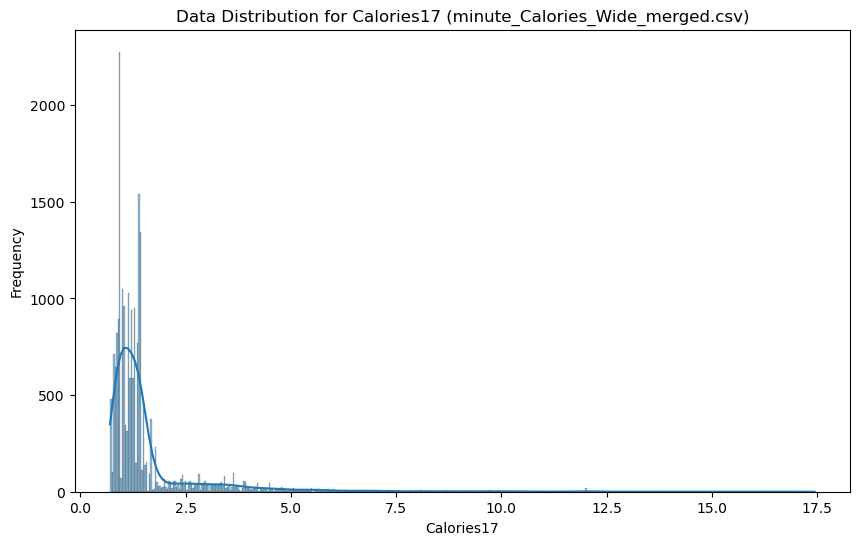

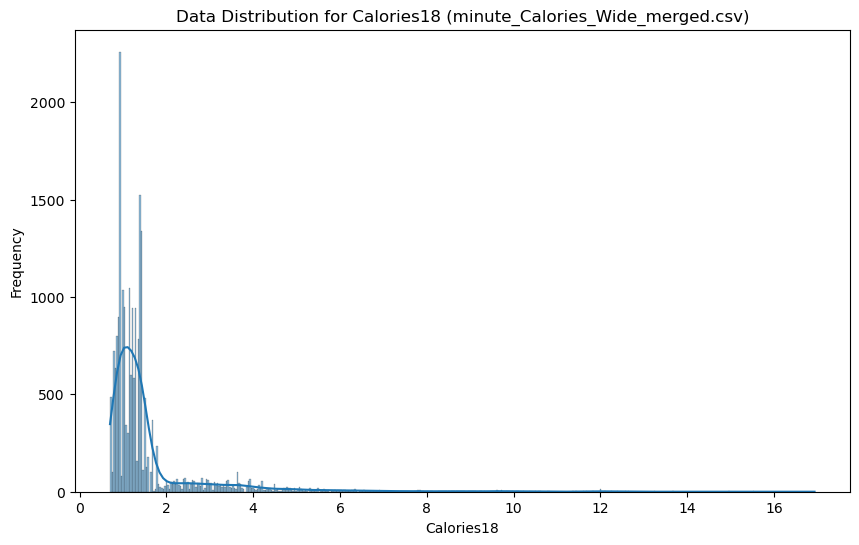

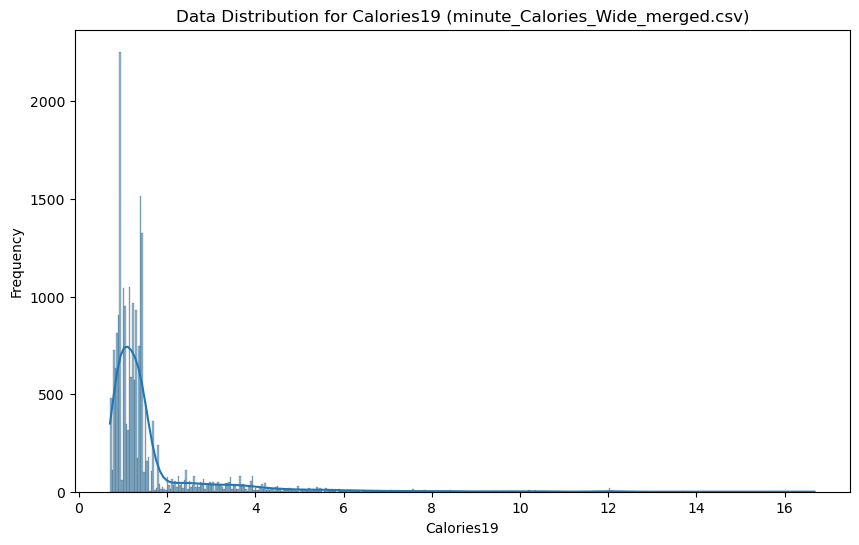

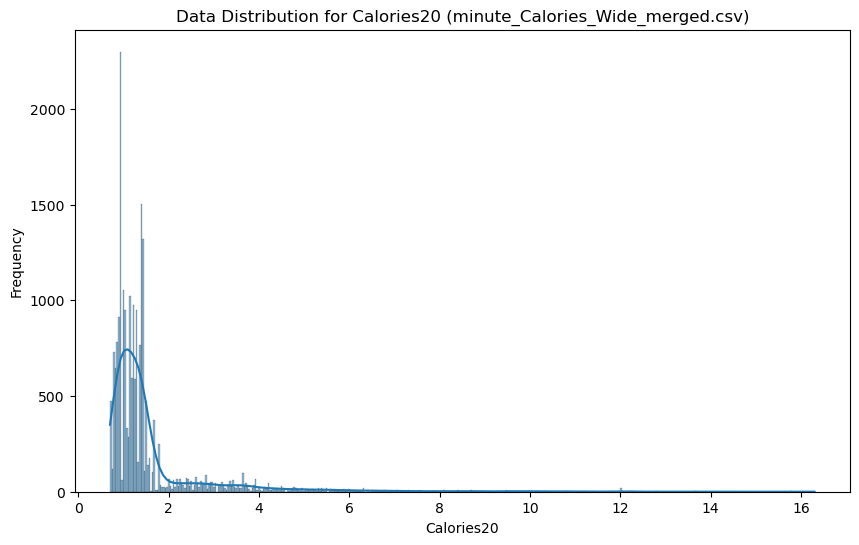

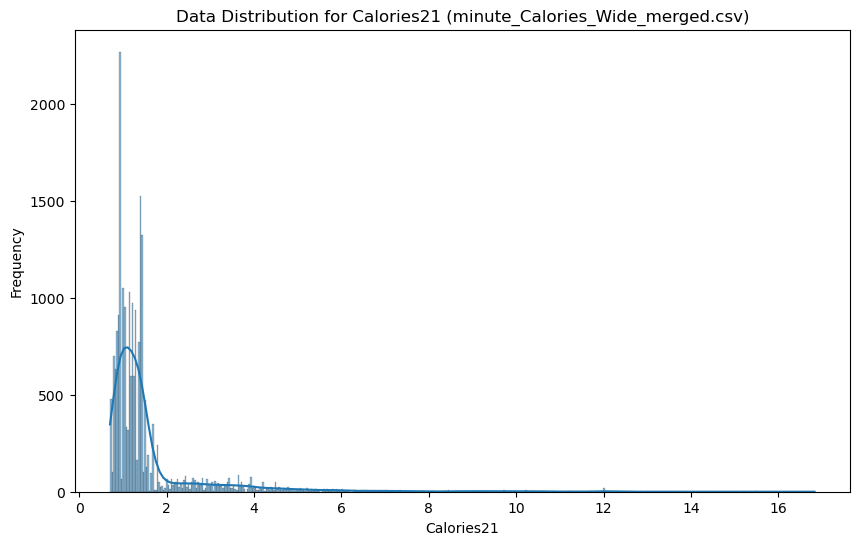

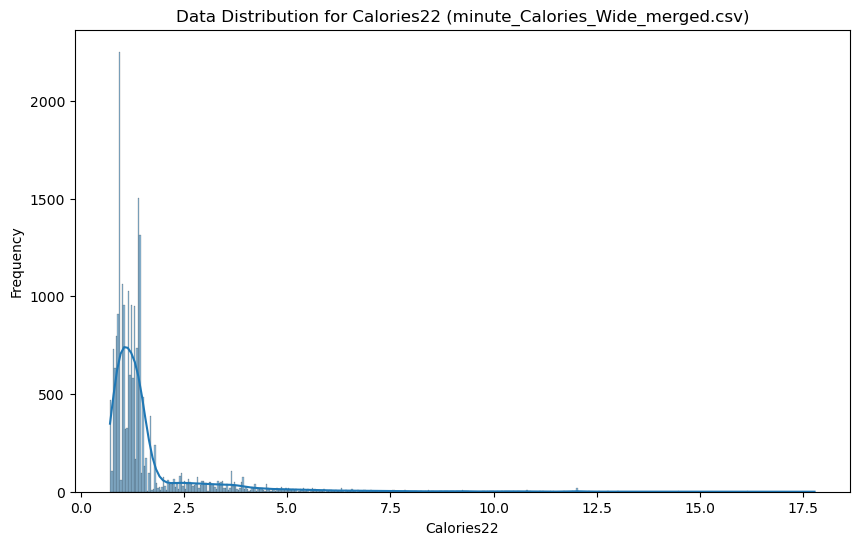

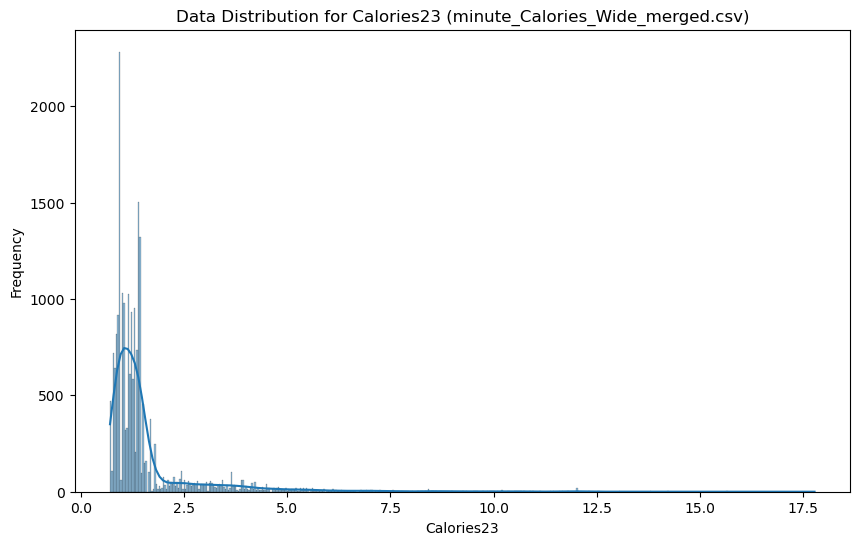

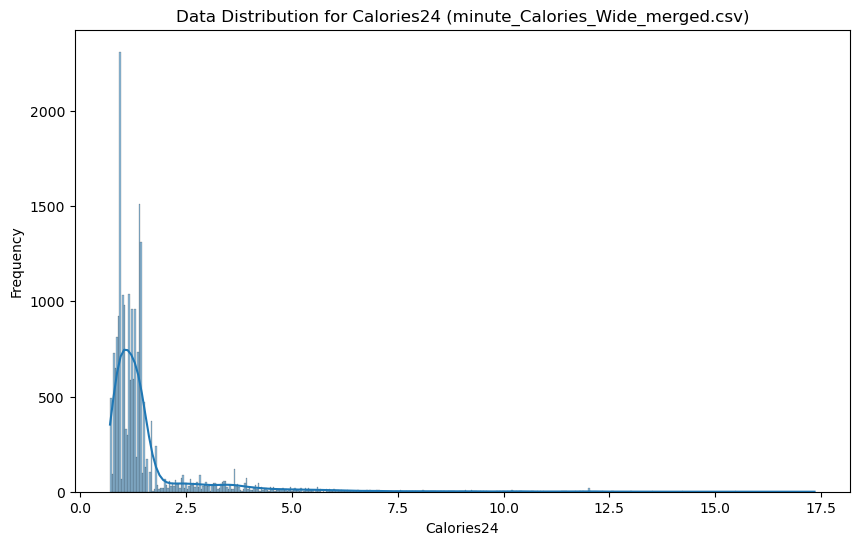

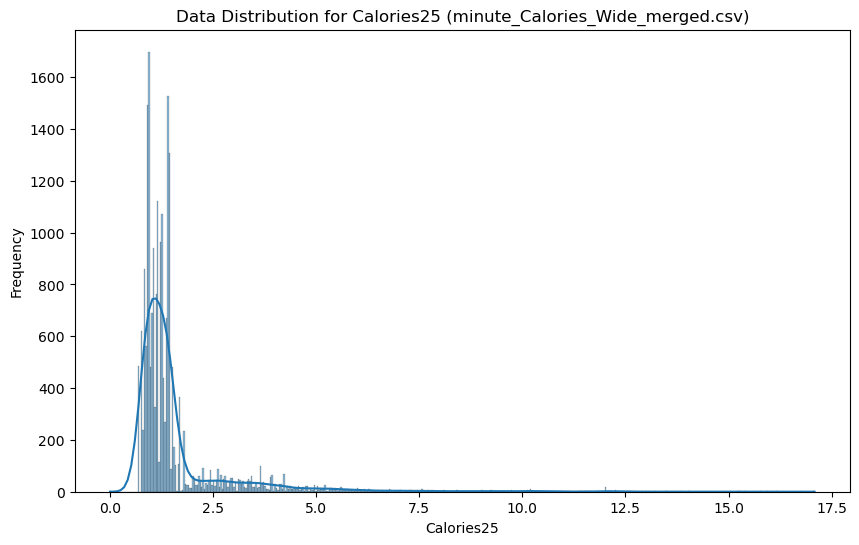

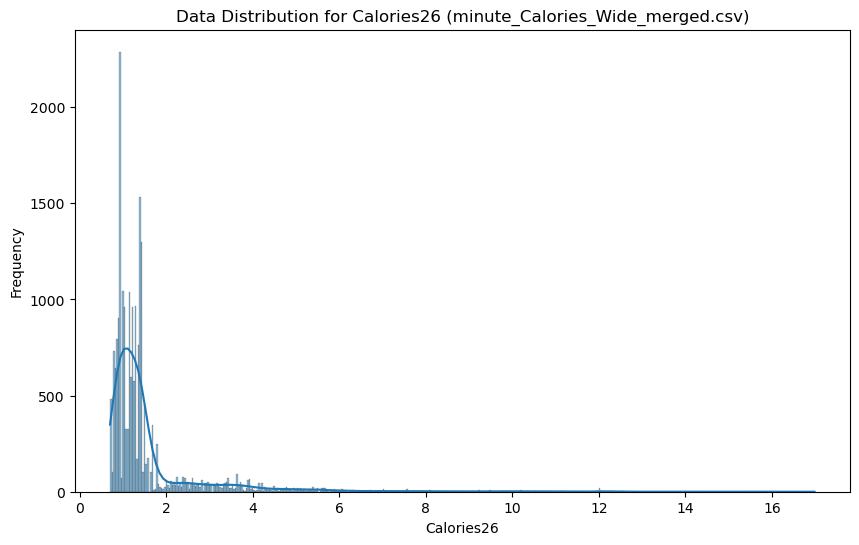

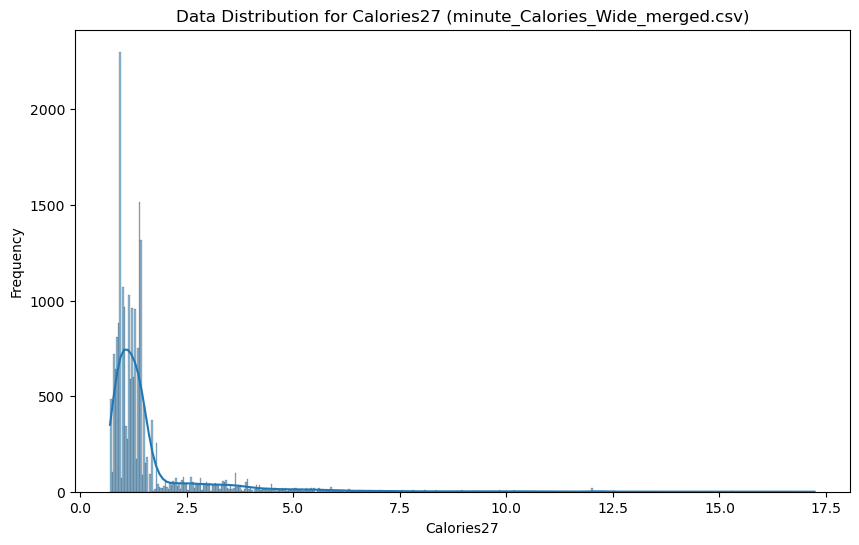

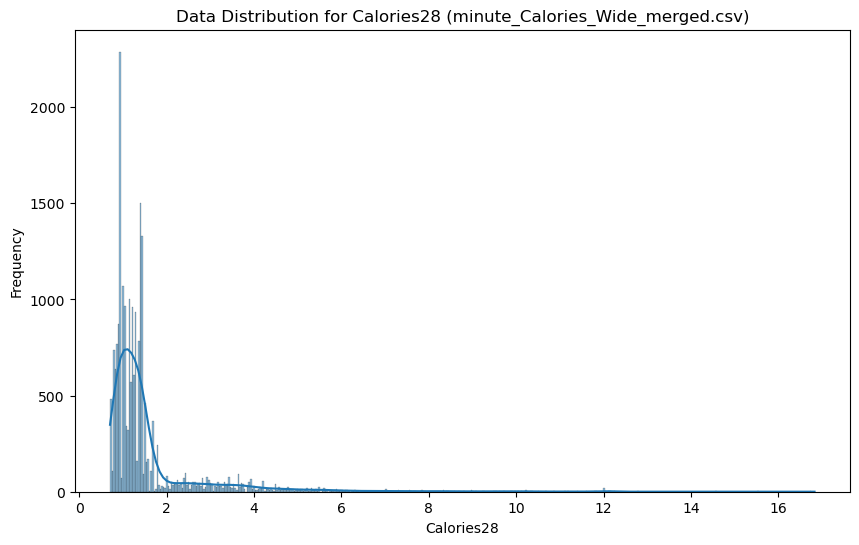

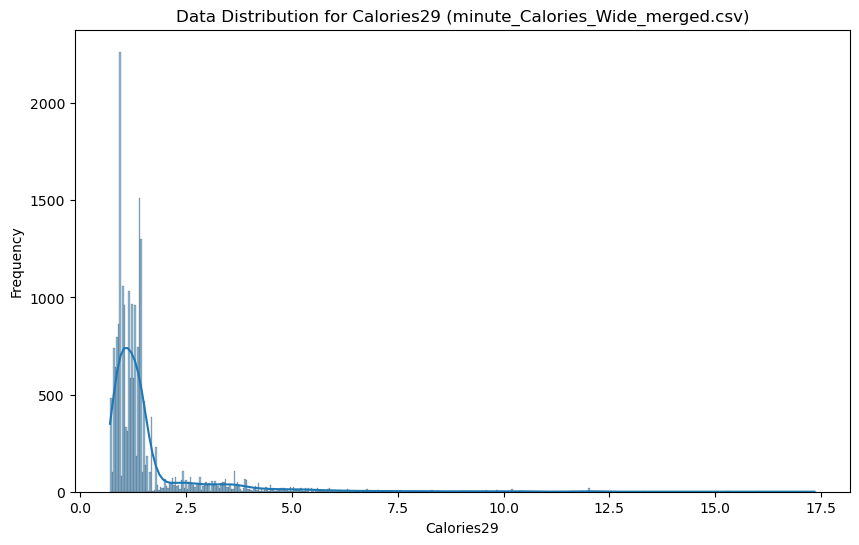

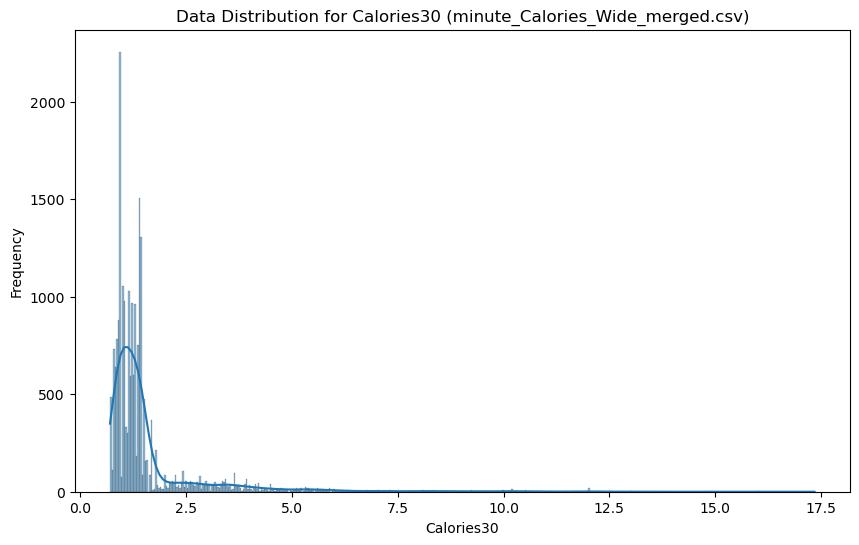

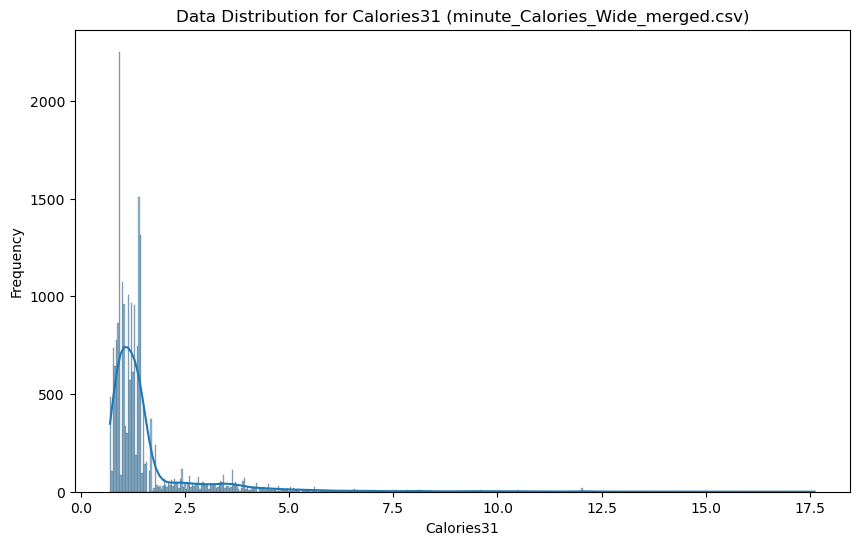

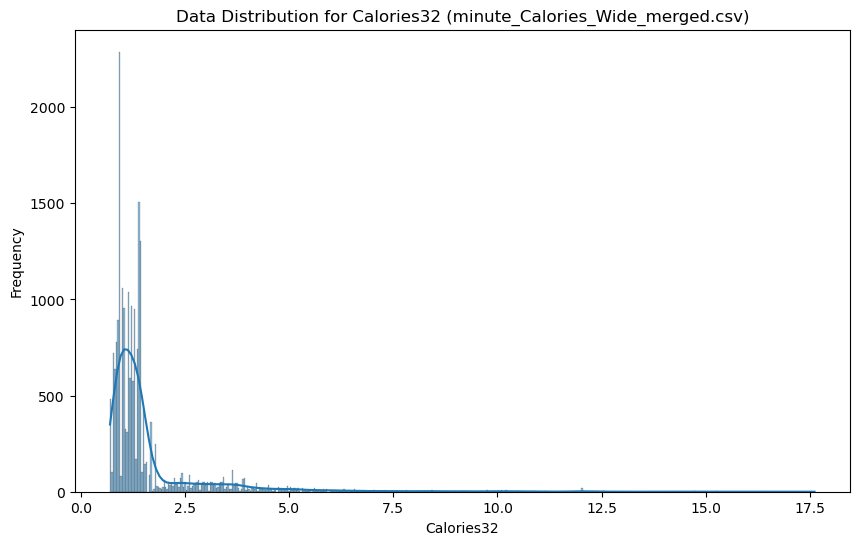

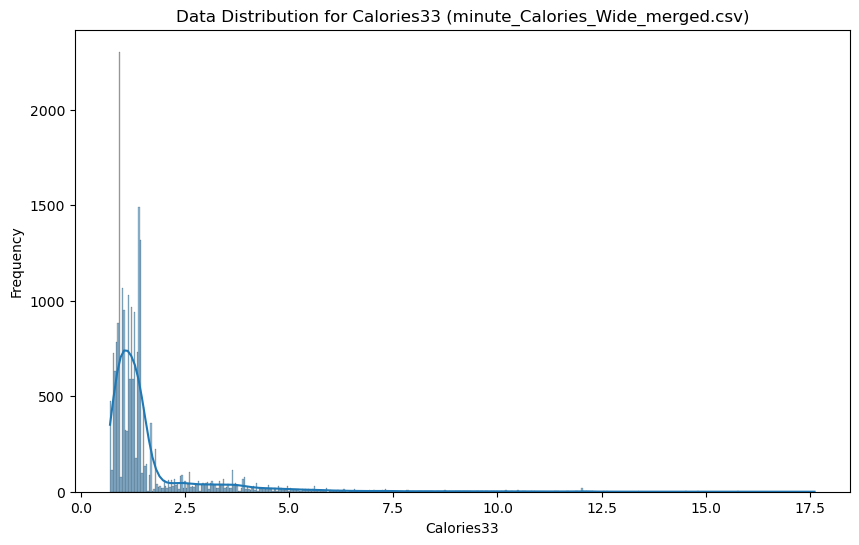

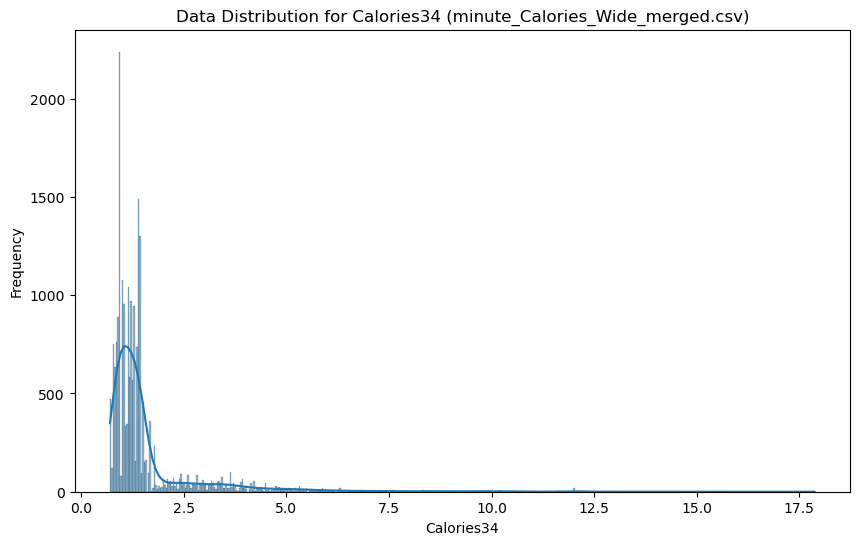

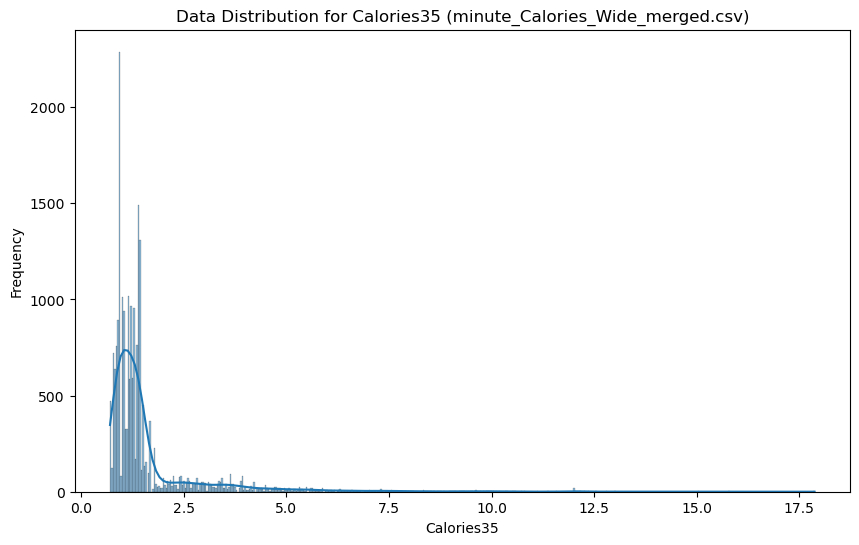

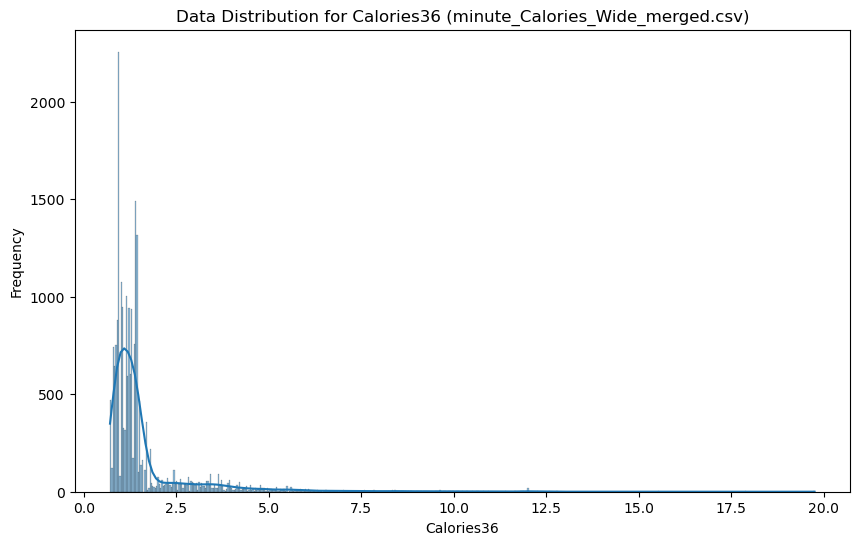

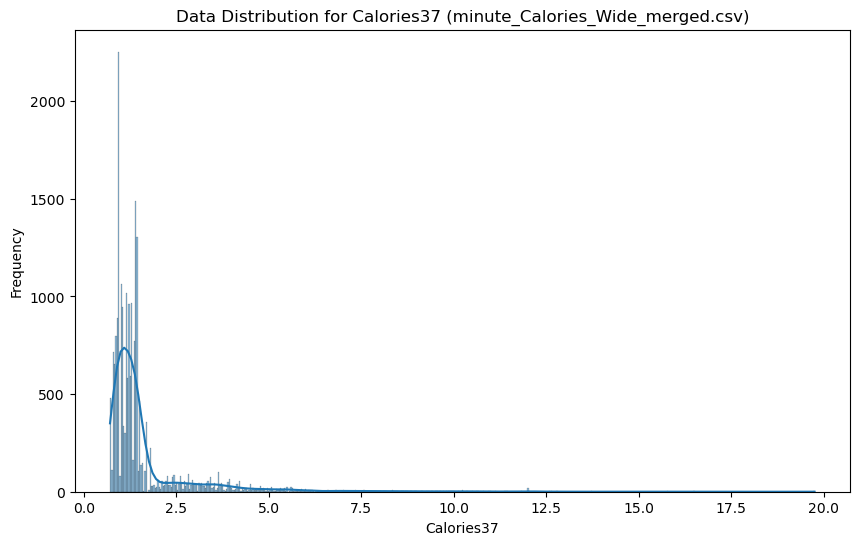

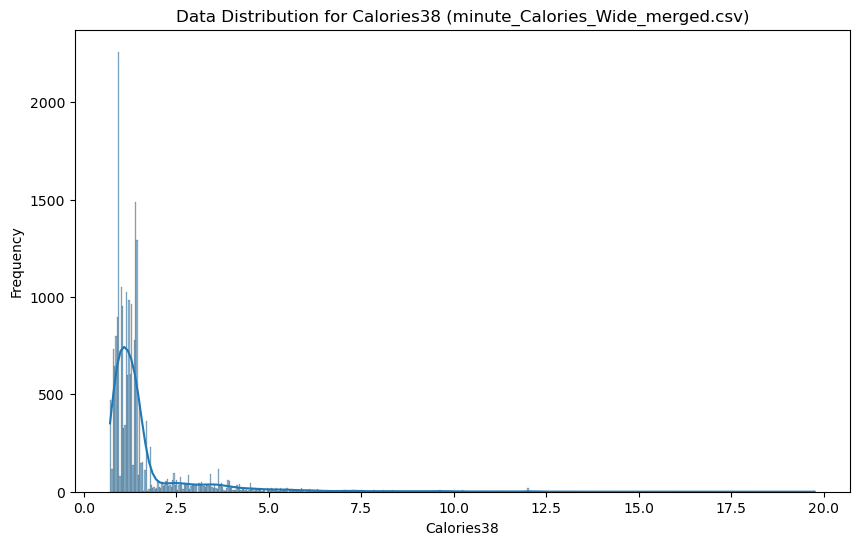

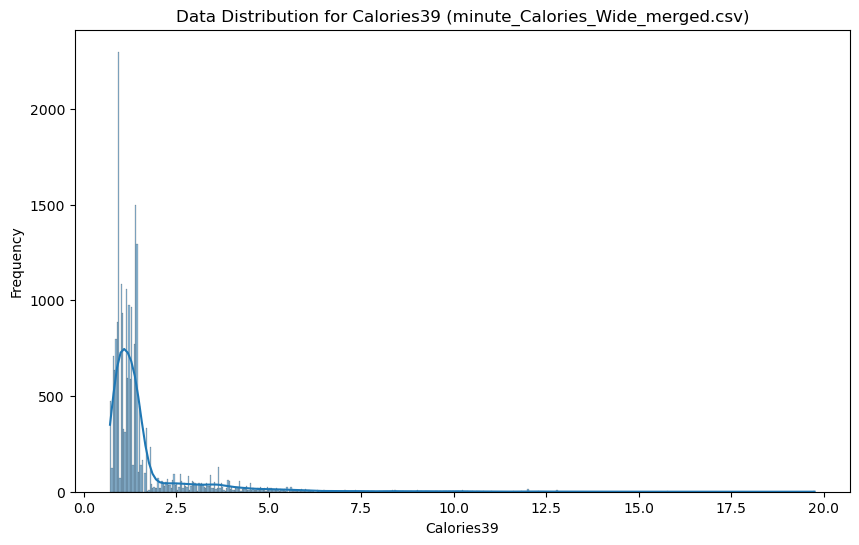

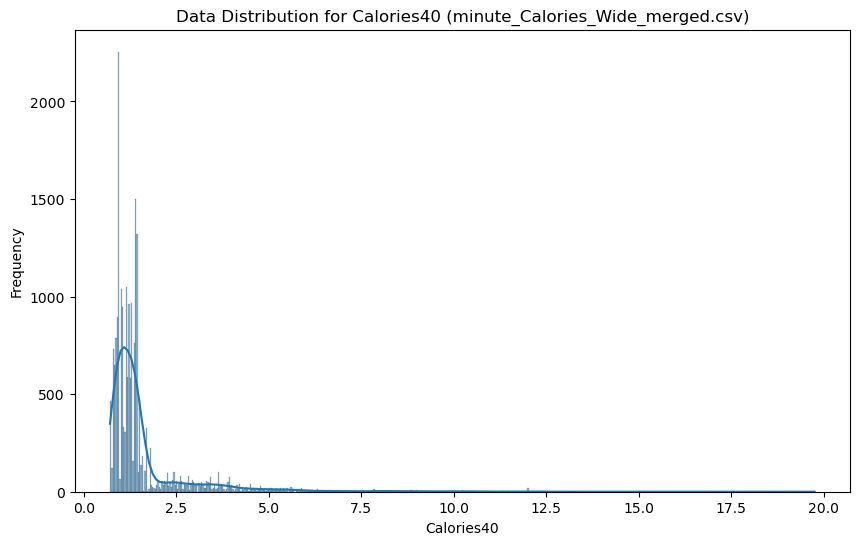

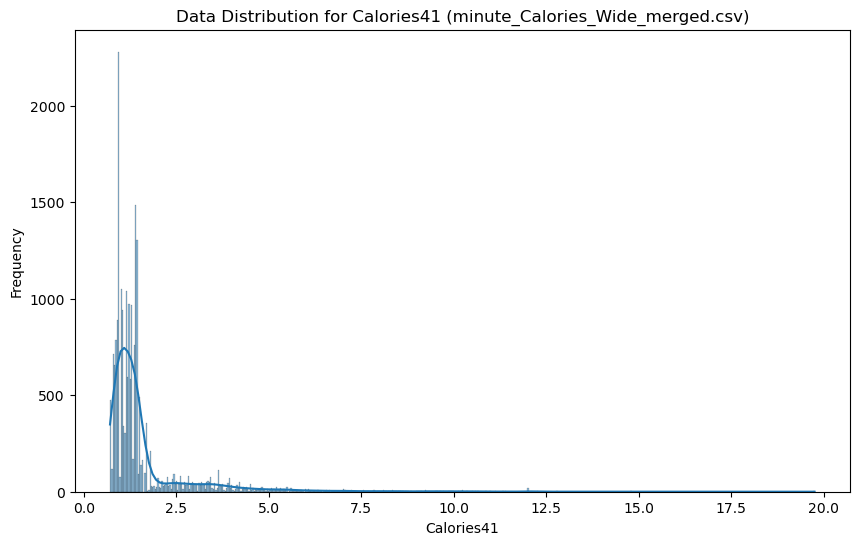

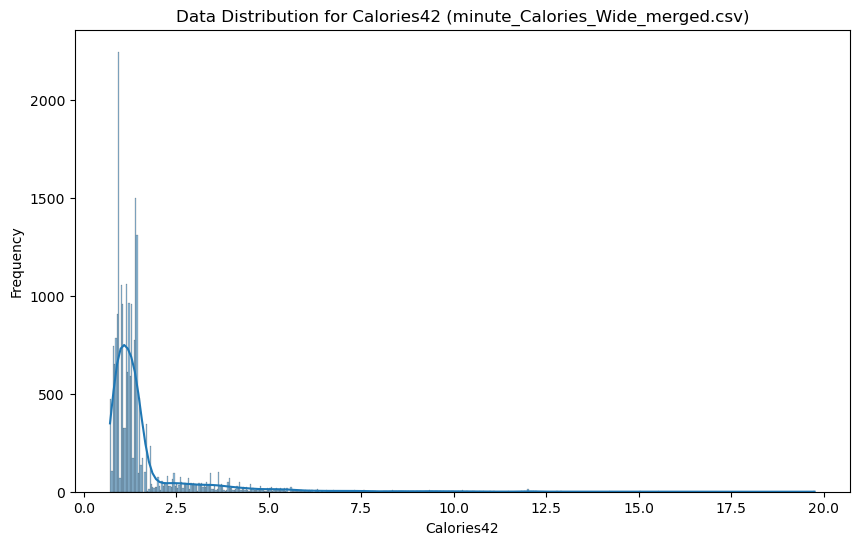

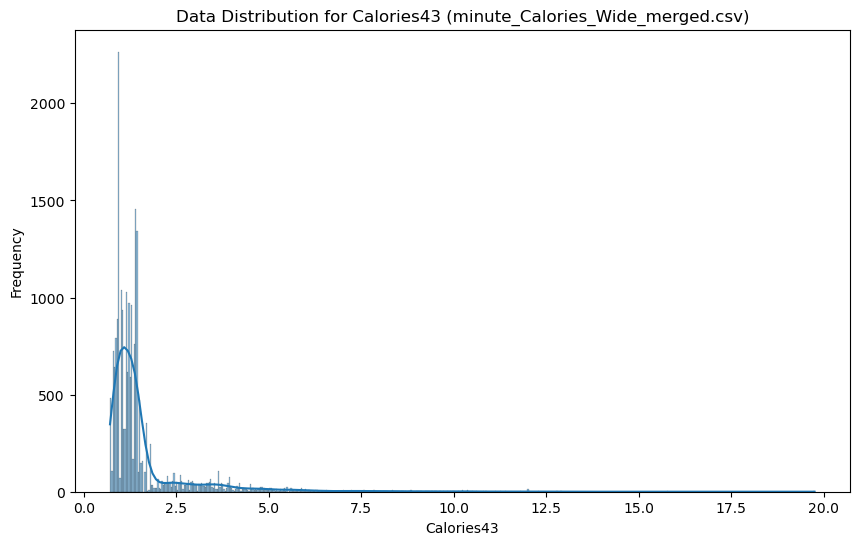

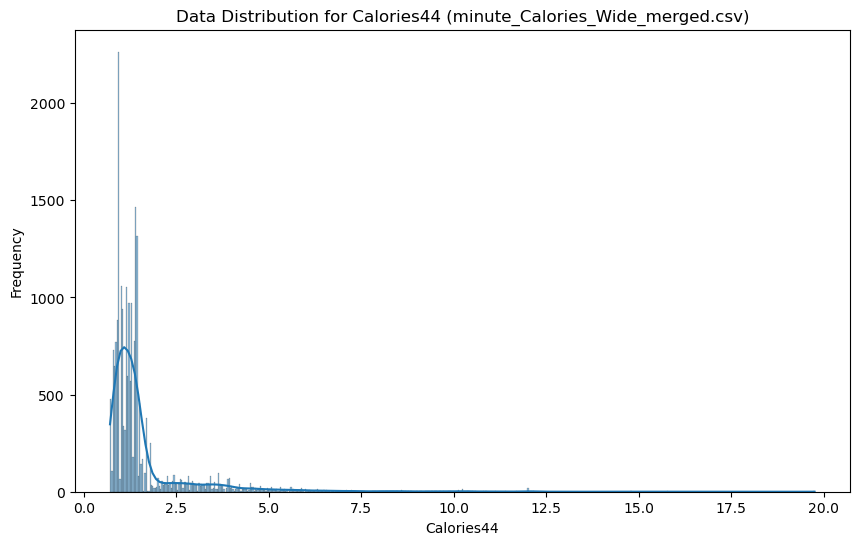

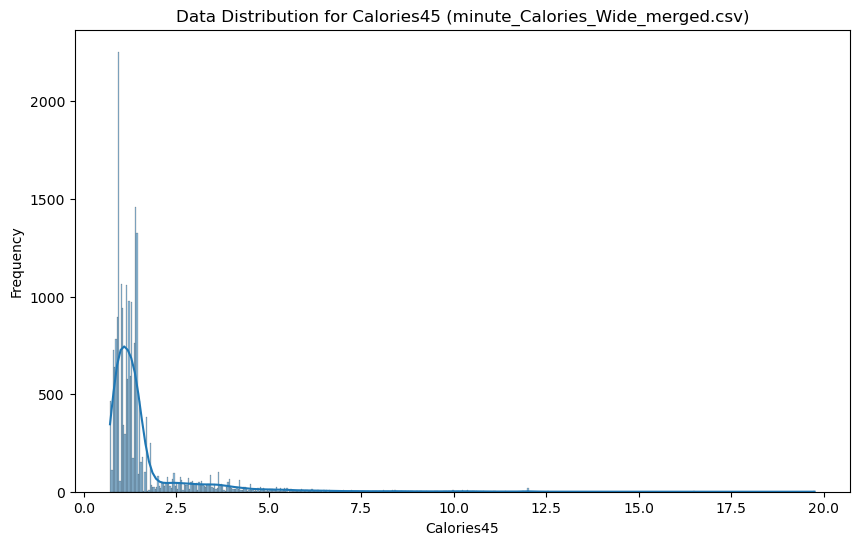

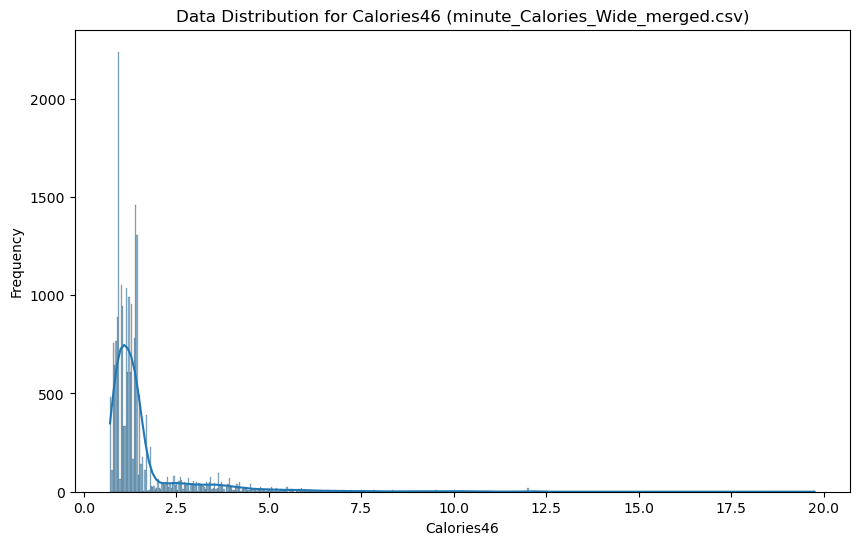

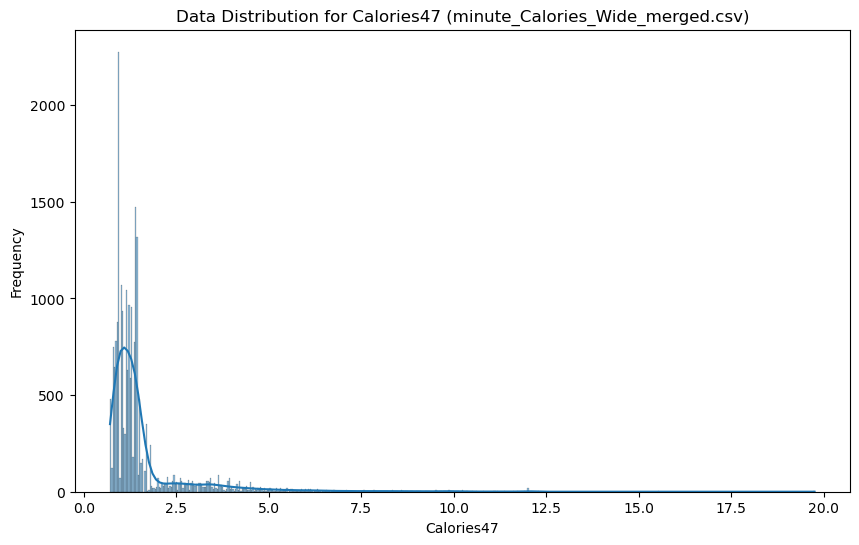

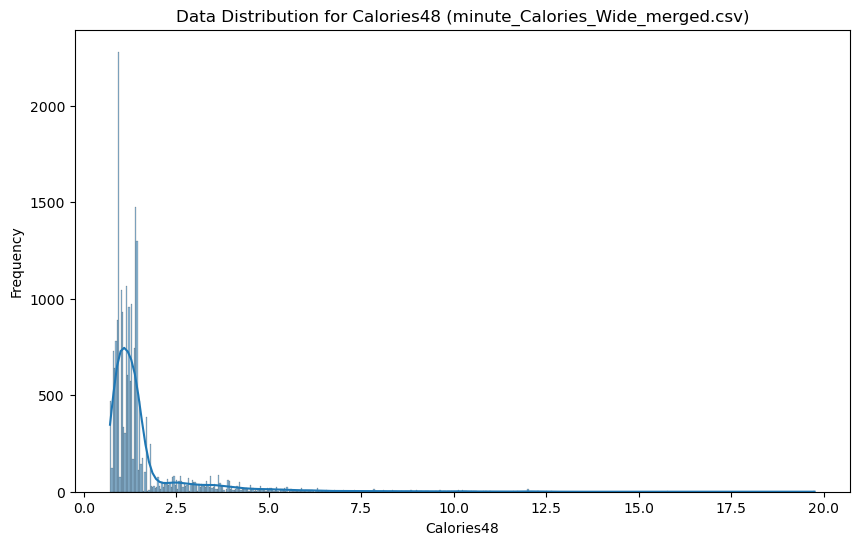

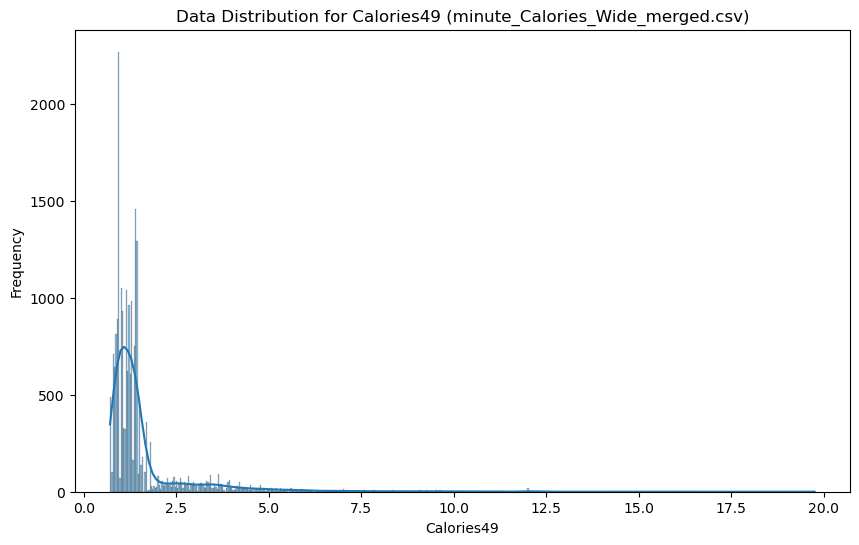

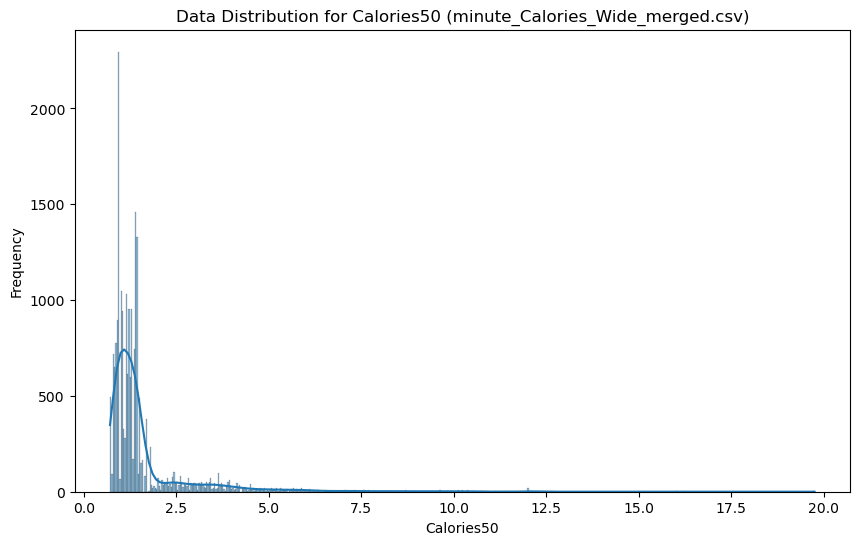

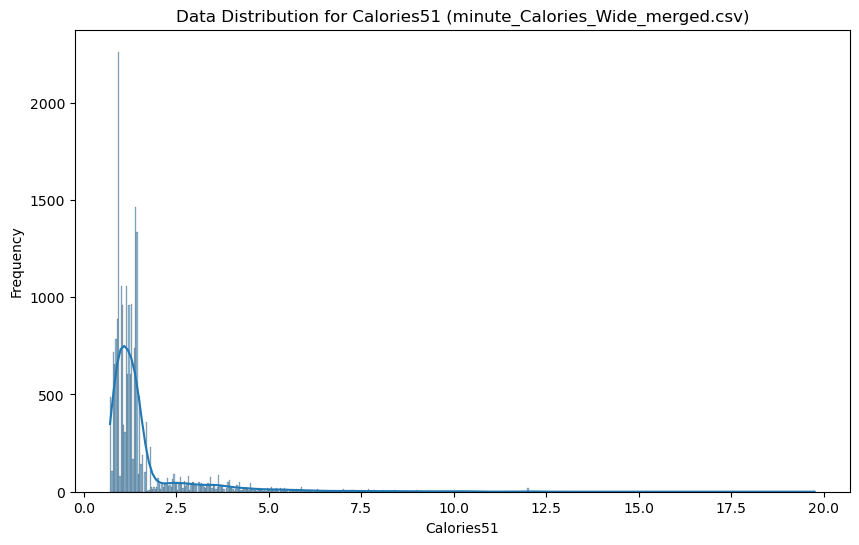

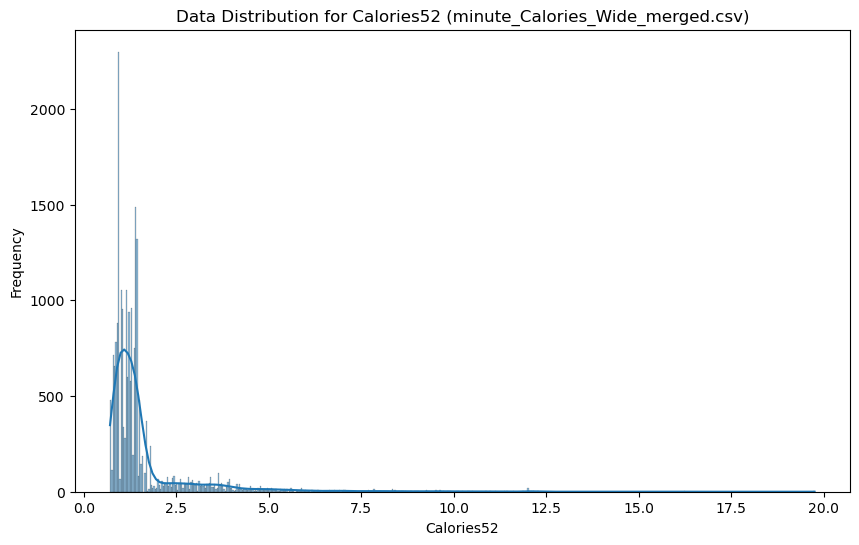

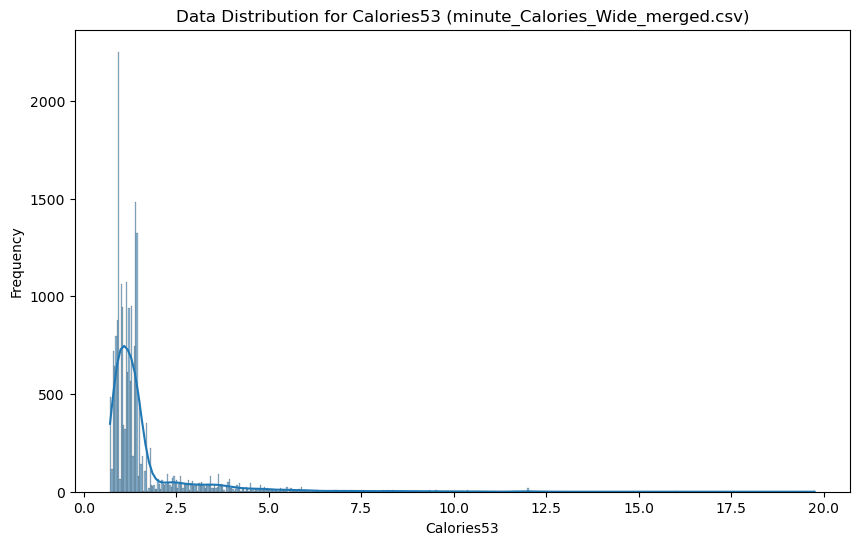

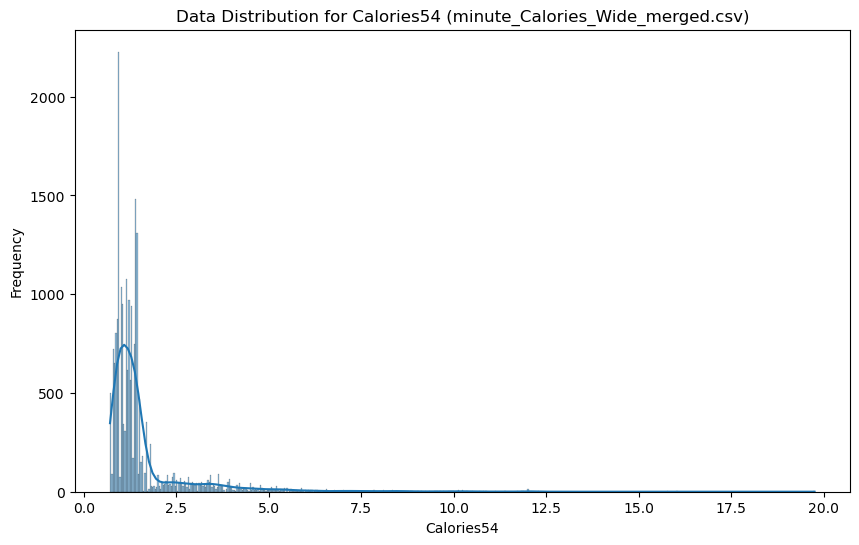

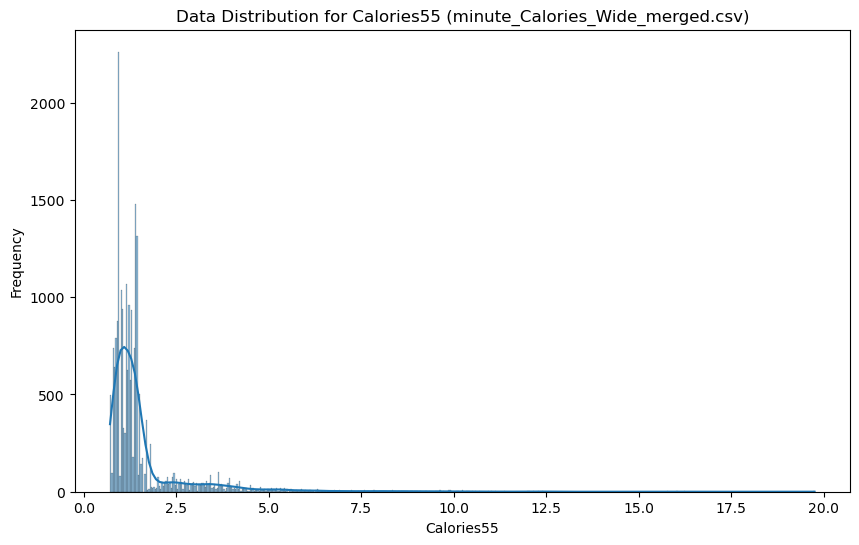

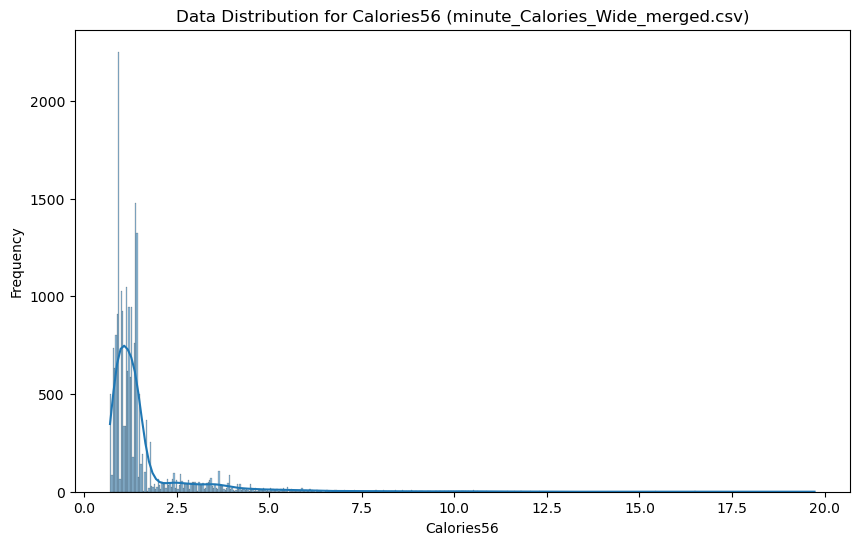

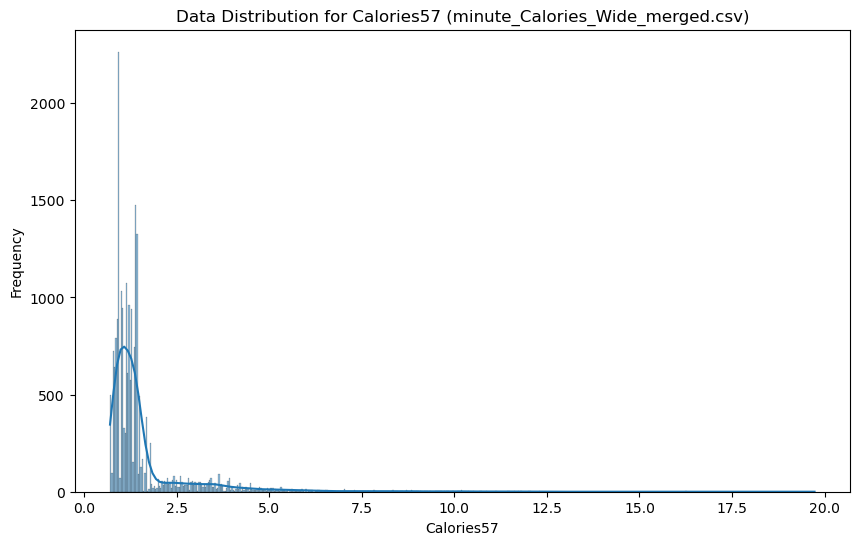

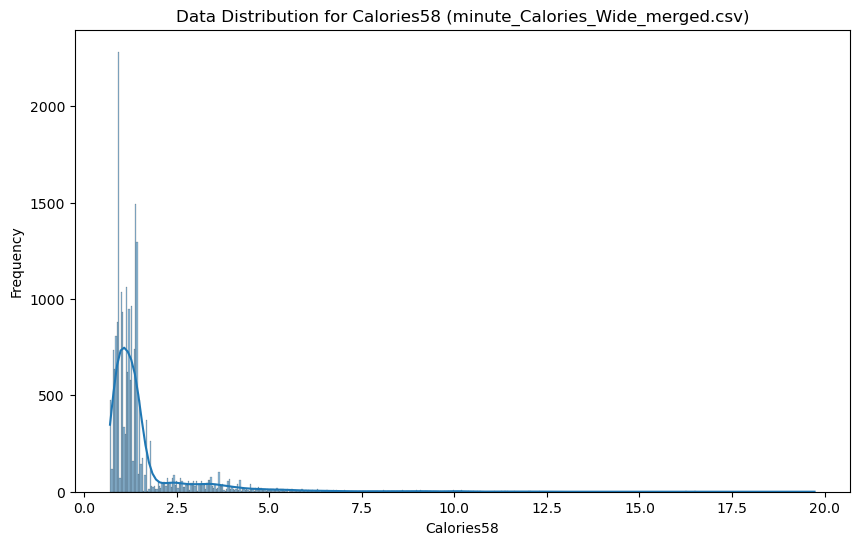

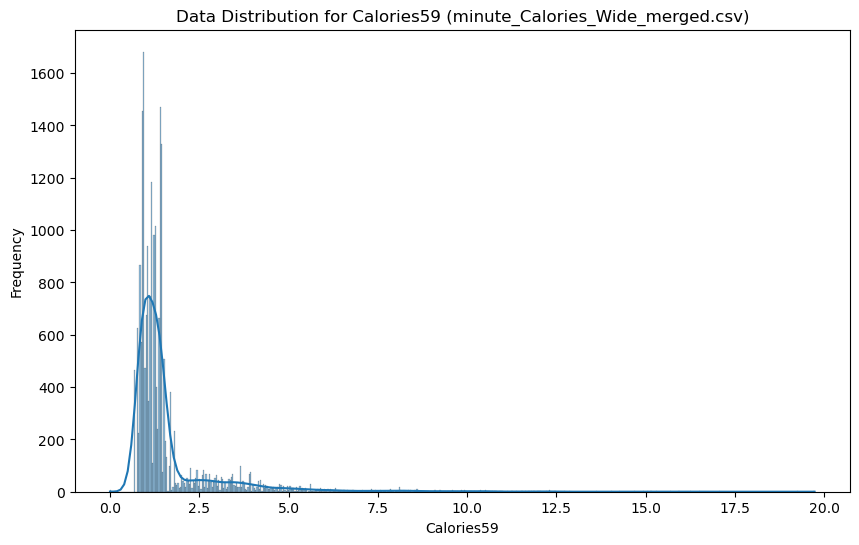

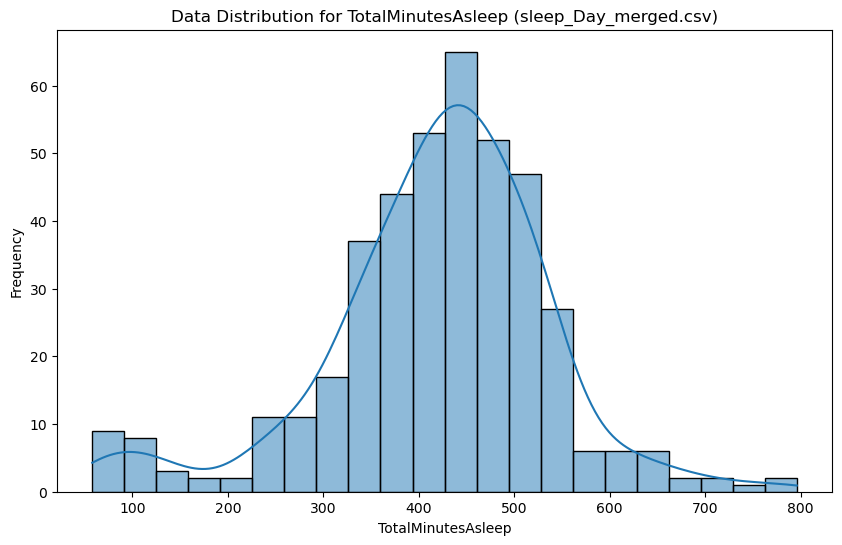

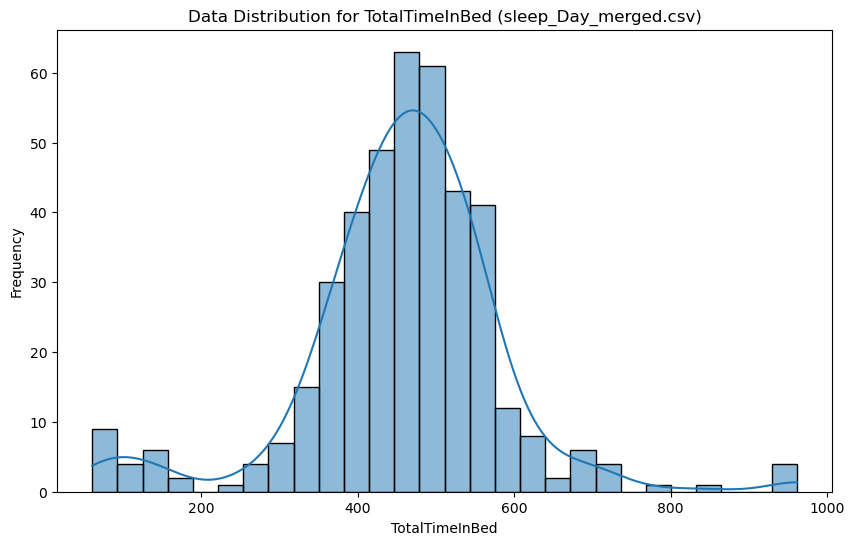

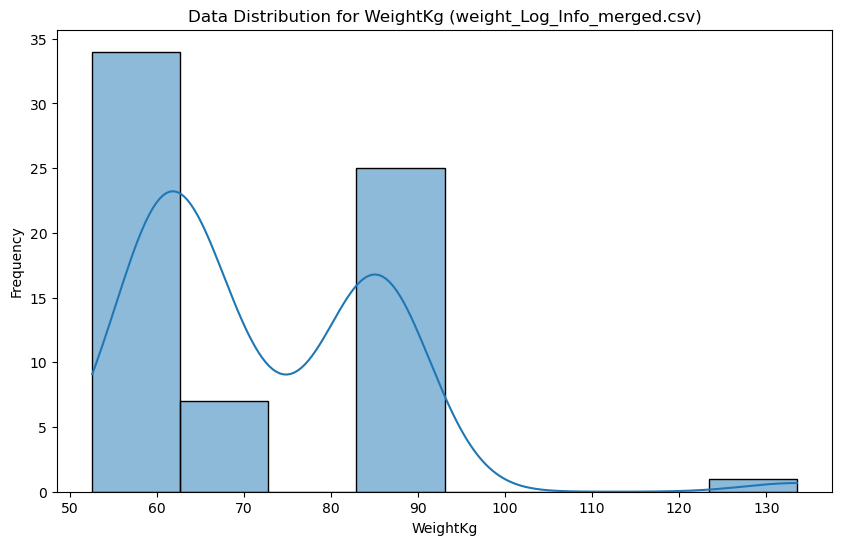

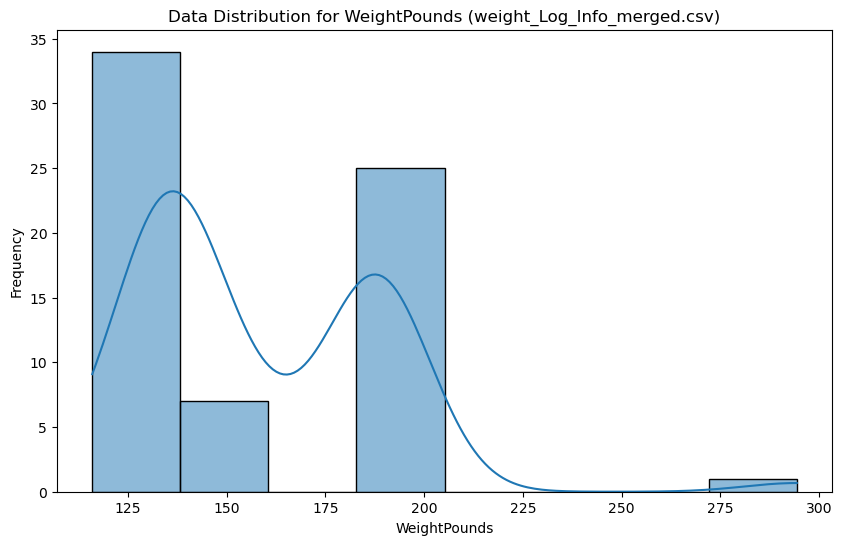

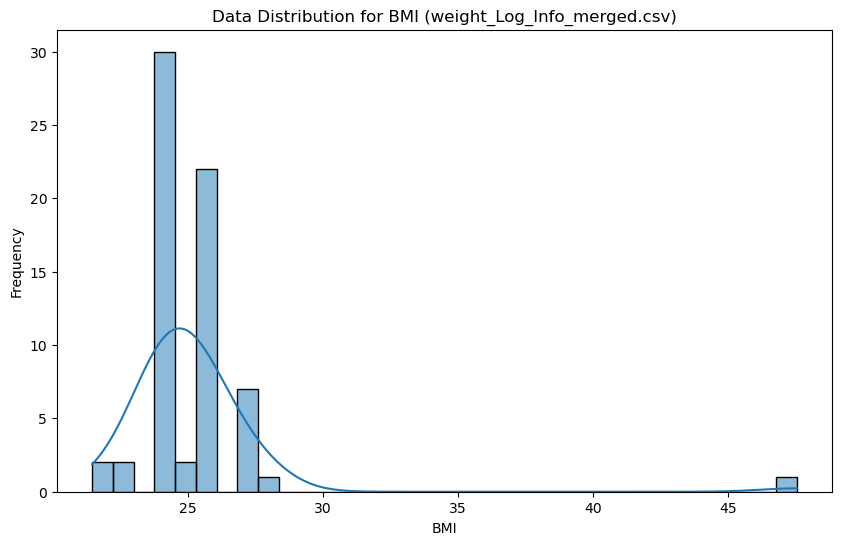

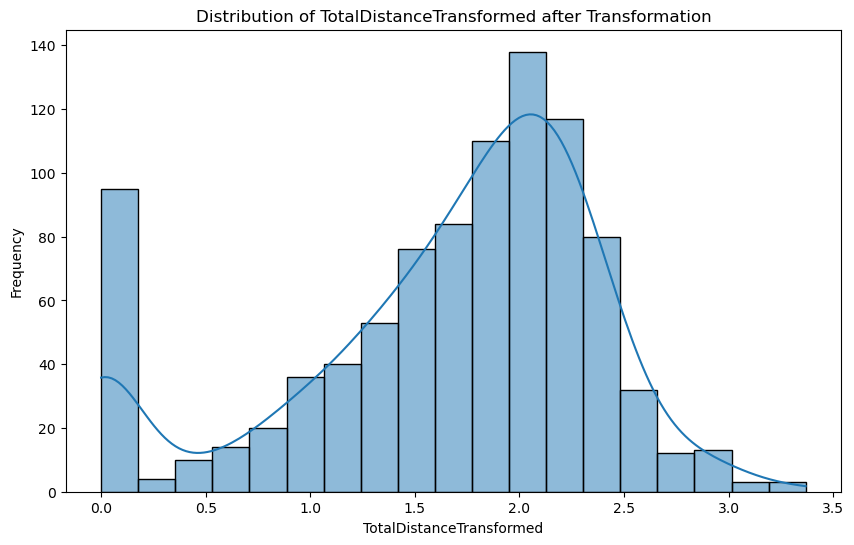

KeyError: 'TotalDistance'

In [11]:
#chain the functions

# 1. clean duplicates
cleansed_data_frames_duplicates = handle_duplicates(data_frames)

# 2. clean missing values using the cleaned data frames from duplicates
cleansed_data_frames_missing_values = handle_missing_values(cleansed_data_frames_duplicates)

# 3. Unpack the returned tuple and classify datatypes using cleansed data_frames from missing values
numeric_columns_all, datetime_columns_all, date_columns_all, categorical_columns_all, cleansed_data_frames_datatypes = classify_datatypes(cleansed_data_frames_missing_values)

# 4. Categorize numeric columns into count and measurements using unpacked cleansed data_frames from classify_datatypes function
count_columns_all, measurement_columns_all, cleansed_data_frames_classify_numbers = classify_numeric_columns(cleansed_data_frames_datatypes, numeric_columns_all)

# 5. Call the function
cols_with_skewness, cols_with_kurtosis, cols_with_outliers, cleansed_data_frames_viz_numeric = visualize_numerical_data(cleansed_data_frames_classify_numbers, measurement_columns_all)

# 6. Transform datapoint with skeweness, kurtosis and outliers:
transformed_data_frames, skewness_after, kurtosis_after, outlier_after = transform_numerical_data(cleansed_data_frames_viz_numeric, cols_with_skewness,
                                                                                                  cols_with_kurtosis, cols_with_outliers, measurement_columns_all)

In [ ]:
# Example usage:
transformed_data_frames = transform_numerical_data(cleansed_data_frames_viz_numeric, measurement_columns_all)

In [ ]:
outlier_after

In [ ]:
skewness

In [ ]:
transformed_data_frames

<b>5. Normalization or Scaling:</b>

Do the values need to be normalized or scaled to ensure they are on a comparable scale?

<b>6. Relationships Between Variables:</b>

Are there nonlinear relationships between variables that need to be captured?

Do interaction terms or polynomial features need to be included?

<b>7. Model Assumptions:</b>

Do the statistical or machine learning models used have specific assumptions about the data distribution or relationships between variables?

Do transformations need to be applied to meet these assumptions?

<b>8. Interpretability:<b>

How will the transformations affect the interpretability of the data?

Will the transformations alter the original scale or meaning of the variables?

<b>9. Handling Zeros or Negative Values:</b>

How will zeros or negative values be handled in the data?

Are there transformations that are not applicable due to the presence of zeros or negative values?

<b>12. Data encoding:</b>
    
Do boolean values need to be encoded to 1 for True and 0 for False?

How will data encoding of boolean/or categorical values impact data interpretation and analysis?

Do you need to add comments to indicate the meaning of True (1) and False (0) in the respective columns?

I encoded the boolean values in the 'boolean_column' as integers, where True is represented as 1 and False as 0."

In [ ]:
import pandas as pd

# Assuming df is your DataFrame and 'boolean_column' is the boolean column
df['boolean_column'] = df['boolean_column'].astype(int)

# Alternatively, you can use a mapping function
# df['boolean_column'] = df['boolean_column'].map({True: 1, False: 0})

<b>Datetime Decomposition:</b>

This term describes the process of breaking down a datetime variable into its constituent parts, such as date and time components.

Do datetime values need to be split into separate date and time columns?

How will splitting datetime values impact subsequent analysis or modeling tasks?

<b>Row Identification:</b>

This term describes the process of assigning a unique identifier to each row in a dataset.

Is it necessary to add a unique identifier to each row in the dataset?

How will the addition of a unique ID affect data manipulation and analysis?

"I performed row identification by adding a unique ID to each row in the DataFrame."

In [ ]:
    # Initialize serial number
    serial_number = 1
    
    def generate_unique_id(file_name):
        """
        Generate a unique ID based on the file name and auto-incrementing serial number.
        
        Args:
        - file_name (str): Name of the file.
        
        Returns:
        - str: Unique ID.
        """
        nonlocal serial_number  # Use the serial_number variable from the outer function
        initials = ''.join(word[0].upper() for word in file_name.split('_'))
        unique_id = f'{initials}{serial_number}'
        serial_number += 1  # Increment serial number
        return unique_id

In [ ]:
min(data_frames[6]['AverageIntensity'])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming outliers DataFrame contains the outlier observations
# Assuming the column with outliers is 'Column_with_outliers'
# Replace 'Column_with_outliers' with the actual column name

# Plot a boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=data_frames[6]['AverageIntensity'])
plt.title('Boxplot of Column with Outliers')
plt.xlabel('Column Name')
plt.show()


In [ ]:
# Plot a boxplot
plt.figure(figsize=(8, 6))
sns.histplot(data=data_frames[6]['AverageIntensity'])
plt.title('Histplot of Column with Outliers')
plt.xlabel('Column Name')
plt.show()

In [ ]:
from scipy.stats import boxcox

# Apply Box-Cox transformation
transformed_data, lambda_value = boxcox(df['AverageIntensity'] + 1)  # Adding 1 to handle zero values
df['AverageIntensityTransformed'] = transformed_data

In [ ]:
data_frames[6]

In [ ]:
# Plot a boxplot
plt.figure(figsize=(8, 6))
sns.histplot(data=data_frames[6]['AverageIntensityTransformed'])
plt.title('Histplot of Column with Outliers')
plt.xlabel('Column Name')
plt.show()

In [ ]:
# Plot a boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=data_frames[6]['AverageIntensityTransformed'])
plt.title('Histplot of Column with Outliers')
plt.xlabel('Column Name')
plt.show()

In [ ]:
data_frames[17].info()

In [ ]:
data_frames[17]['Fat'].isnull().sum()/len(data_frames[17]['Fat'])*100

In [ ]:
if df[col].iloc[1] like "4/12/2016 12:00:00 AM" => split to date, time and am/pm column and convert to appropriate datatype

if df[col].iloc[1] like "4/12/2016" => convert to appropriate datatype (date)

In [ ]:
SOURCE_USERNAME = 'fitbase'
SOURCE_PASSWORD = 'fitbase'
SOURCE_SERVER = 'localhost'
SOURCE_DATABASE = 'projectfitbase'

DEST_USERNAME = 'fitbase'
DEST_PASSWORD = 'fitbase'
DEST_SERVER = 'localhost'
DEST_DATABASE = 'projectfitbasetransformed'

In [ ]:
# Source database connection string
source_conn_str = f'postgresql://{SOURCE_USERNAME}:{SOURCE_PASSWORD}@{SOURCE_SERVER}/{SOURCE_DATABASE}'

# Destination database connection string
dest_conn_str = f'postgresql://{DEST_USERNAME}:{DEST_PASSWORD}@{DEST_SERVER}/{DEST_DATABASE}'

# Establish connections to source and destination databases
source_engine = create_engine(source_conn_str)
dest_engine = create_engine(dest_conn_str)

# Reflect metadata from source database
metadata = MetaData()
metadata.reflect(bind=source_engine)

# List to store extracted dataframes
extracted_datax = []

# Loop through each table in the source database
for table_name, table in metadata.tables.items():
    # Extract data from the current table
    with source_engine.connect() as source_conn:
        extract_query = table.select()
        extracted_data = source_conn.execute(extract_query).fetchall()
        
        # Convert extracted data to DataFrame
        df = pd.DataFrame(extracted_data, columns=table.columns.keys())
        
        # Append DataFrame to the list
        extracted_datax.append(df)

    # Transform data as needed
    #transformed_data = transform_data(extracted_data)

    # Load transformed data into the destination database
    #with dest_engine.connect() as dest_conn:
        #dest_conn.execute(table.insert(), transformed_data)

print("ETL process completed successfully.")
